In [1]:
from google.colab import drive     
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/ICS_IDS")
os.listdir()

['.ipynb_checkpoints',
 'Saved Files',
 'Presentations',
 'Reports',
 'Results',
 'bestmodel_dnn.pk',
 'bestmodel_dnn_dir.pk',
 'processed_data.csv',
 'final_results.pkl',
 'ib.pkl',
 'iw.pkl',
 'nb.pkl',
 'nw.pkl',
 'to.pkl',
 'RandomForests.pkl',
 'SVMLinear.pkl',
 'SVMRBF.pkl',
 'DecisionTrees.pkl',
 'NaiveBayes.pkl',
 'LogisticRegression.pkl',
 'bestmodel_dnn_altered.pk',
 'bba.pkl',
 'wba.pkl',
 'adversarial_accuracy.pkl',
 'ae.pkl',
 'smodel_altered.pkl',
 'defensive_distaillation.pkl']

In [3]:
# For the JRipper Rule based algorithm
! pip install wittgenstein

# Updated SKLearn
! pip install -U scikit-learn

# PDP Plots
! pip install pdpbox

# Install SHAP
! pip install shap

     |████████████████████████████████| 124 kB 5.2 MB/s 
     |████████████████████████████████| 22.3 MB 20.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 34.0 MB 39 kB/s 
     |████████████████████████████████| 13.1 MB 6.5 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=168838f7d9ebfe05ed59eebf8aea98cf0504852675173bb84e039ef708da5ab3
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

     |████████████████████████████████| 356 kB 5.4 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491655 sha256=c9e4bbd71fc4113838d51f43a654f92e2dba4a70b755401d7c1c6084bd648b51
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [4]:
# Importing the required libraries

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import wittgenstein as lw
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
import shap
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader

In [5]:
# Essential functions 

def performance(y_test, y_pred): 
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred, digits=5))


def time_series(X, y, time_step = 20):

  Xt = []
  yt = []

  for i in range(0, len(X)- time_step + 1 , 1):
    Xt.append(X[i:i+time_step].reshape(-1))
    
    if(np.sum(y[i:i+time_step])>2):
      yt.append('1')
    else:
      yt.append('0')

  return np.array(Xt).astype('float32'), np.array(yt).astype('float')

def plot_pdp(clf, data, features):
  for f in features:
    print("Currently plotting {}".format(f))
    from pdpbox import pdp, get_dataset, info_plots
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=data, model_features=data.columns, feature=f)
    fig, axes = pdp.pdp_plot(pdp_goals, f)
    plt.show()
    print("-------------------------------------------")
    return fig, axes

def get_importances(clf, data, feature):
  from sklearn.inspection import permutation_importance
  r = permutation_importance(clf, data.drop([feature], axis=1), data[feature], n_repeats=5, scoring="accuracy", random_state=0)

  imp_features = []
  for i in range(len(data.columns)-1):
    if(r['importances_mean'][i] > 0):
      imp_features.append(data.columns[i])
      print(data.columns[i] + " " + str(r['importances_mean'][i]))

  return imp_features

In [10]:
# Reading and creating the required datasets 

df = pd.read_csv('processed_data.csv')
df = df.drop(['Time', 'Slave address'], axis=1)
crc_mean = 15111.603904190395 
crc_std = 2714.4668815621653


names = list(df.columns[0:-2]) # removing the binary and categorical labels
target = ['normal', 'anomaly']
train, test = train_test_split(df, test_size=0.20, random_state=0)


# # Extracting the attacks datapoints
# only_attack = test[(test['Specific Result']==9.0) | (test['Specific Result']==10.0)]
# target_attack = only_attack['Binary Result']
# only_attack = only_attack.drop(['Cat Result', 'Specific Result'], axis=1)

# ctrain = train['Cat Result'] # contains categorical labels
# train = train.drop(['Cat Result', 'Specific Result'], axis=1)
# ctest = test['Cat Result']
# test = test.drop(['Cat Result', 'Specific Result'], axis=1)


arr = np.array(df)
X = arr
y = arr[:,-3]

#time_series() used for analysing the impact of the temporal relationships
#X, y = time_series(X, y, 30)

X, y = sklearn.utils.shuffle(X,y, random_state=0)
ds = train_test_split(X, y, test_size=0.20, random_state=0)
ytrc = ds[0][:,-1]  # train categorical labels
ds[0] = ds[0][:,:-3]
ytec = ds[1][:,-1] # test catagorical labels
ds[1] = ds[1][:,:-3]

In [7]:
crc_mean = 15111.603904190395 
crc_std = 2714.4668815621653
-0.5 * crc_std + crc_mean, 0.25 * crc_std + crc_mean

(13754.370463409312, 15790.220624580936)

# ML Classifier Analysis

In [ ]:
def compute(clf, dr, names):
  X_train, X_test, y_train, y_test = dr
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))



from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=25, max_depth=50)

from sklearn.svm import SVC
svm_linear = SVC(C=1.5, kernel='linear', probability=True)
svm_rbf = SVC(C=1.5, kernel='rbf', probability=True)

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)

clfs = [rf, svm_linear, svm_rbf, dt, nb, lr]
cl_names = ['RandomForests',  'SVMLinear', 'SVMRBF', 'DecisionTrees', 'NaiveBayes', 'LogisticRegression']


def check(classifiers, classifier_names):
  #os.chdir('./Results/Classifiers/')
  for i in range(len(classifiers)):
    start = time.time()
    clf = classifiers[i]
    ds_temp = ds.copy()
    print("Using classifier: " + classifier_names[i])
    if(cl_names[i][0:3]=='SVM'): # using a smaller dataset to train the SVM models due to time constraints
      ds_temp[0] = ds_temp[0][0:10000]
      ds_temp[2] = ds_temp[2][0:10000]
    print(len(ds_temp[0]))
    compute(clf, ds_temp, classifier_names[i])
    # if(classifier_names[i]=='Decision Trees'):
    #   print("Number of leaves = {}".format(clf.get_n_leaves()))
    print("Time takes = " + str(time.time() - start))
    file_name = str(classifier_names[i]) + ".pkl"
    #pickle.dump(clf, open(file_name, 'wb'))

check(clfs, cl_names)

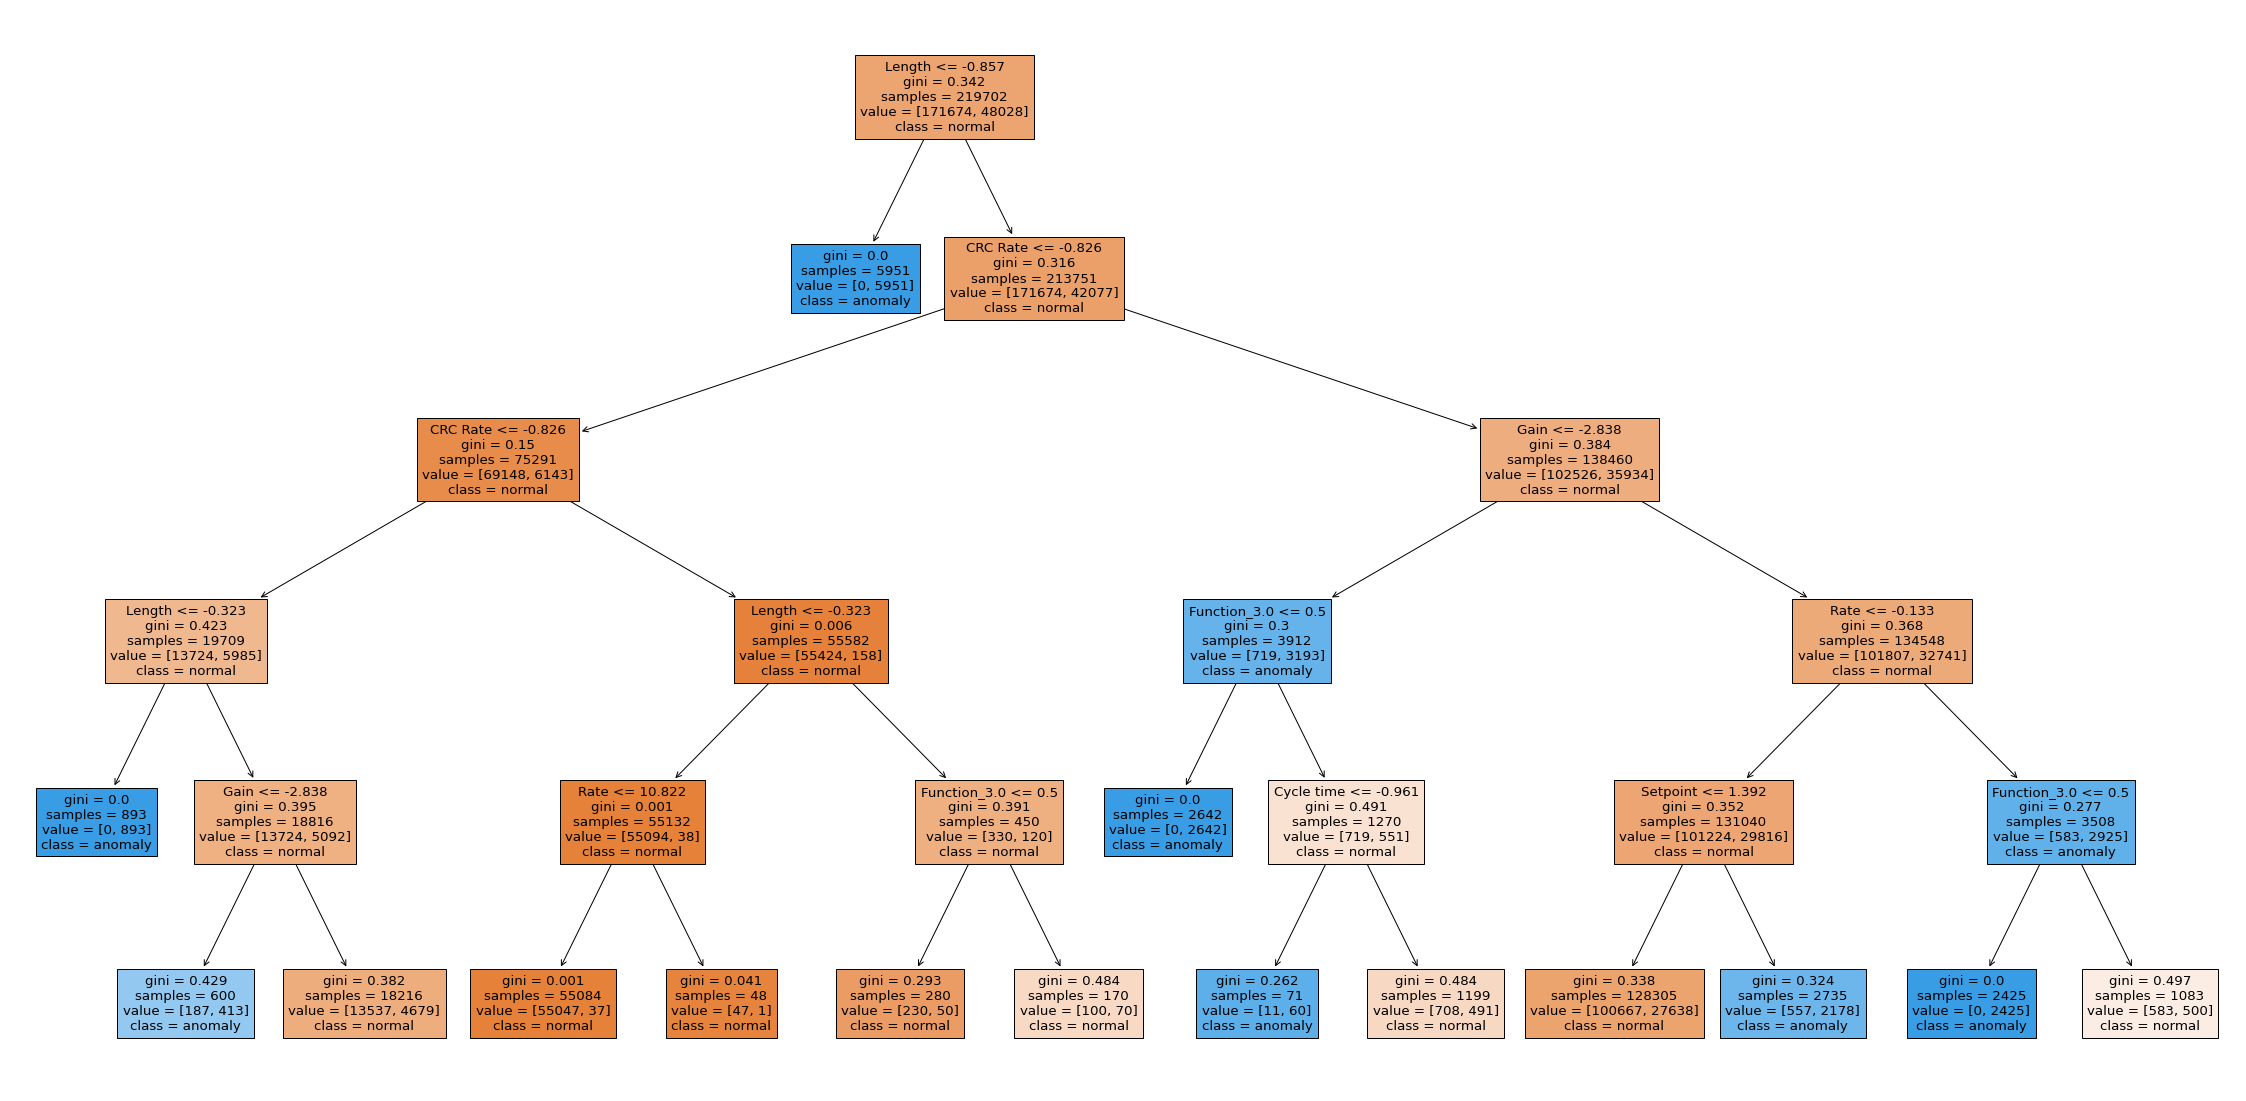

In [ ]:
# Plotting a decision tree 

from sklearn import tree
fig = plt.figure(figsize=(40,20))
_ = tree.plot_tree(dt, 
                   feature_names=names[:-1],  
                   class_names=['normal','anomaly'],
                   filled=True)


In [8]:
# Load all the stored models

cl_names = ['RandomForests',  'SVMLinear', 'SVMRBF', 'DecisionTrees', 'NaiveBayes', 'LogisticRegression']

rf = pickle.load(open('RandomForests.pkl','rb'))
svm_linear = pickle.load(open('SVMLinear.pkl','rb'))
svm_rbf = pickle.load(open('SVMRBF.pkl','rb'))
dt = pickle.load(open('DecisionTrees.pkl','rb'))
nb = pickle.load(open('NaiveBayes.pkl','rb'))
lr = pickle.load(open('LogisticRegression.pkl','rb'))
clfs = [rf, svm_linear, svm_rbf, dt, nb, lr]

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator GaussianNB from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


## Why interpretable ML is not enough for attacking ML models?

Currently plotting CRC Rate


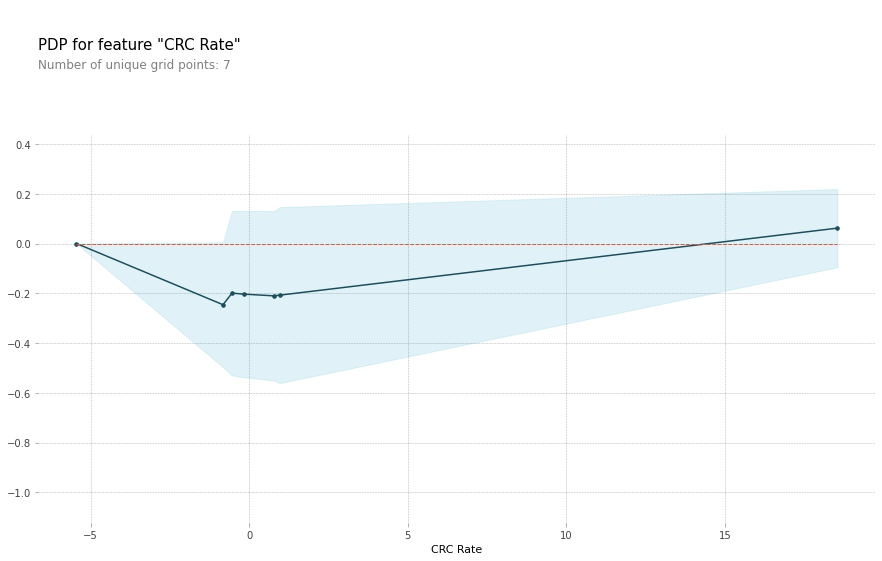

-------------------------------------------
[0.55868149 0.55868149 0.55868149 0.55868149 0.55868149 0.55868149
 0.55868149 0.55868149 0.55868149 0.55868149 0.55820958 0.55815569
 0.55763516 0.55703517 0.55493974 0.55399647 0.55211571 0.54516231
 0.51518302 0.41772831 0.35553403 0.35401043 0.35936783 0.3478031
 0.34737197 0.34412784 0.34434741 0.46549467 0.59319079 0.61355081
 0.61801923 0.61859803 0.61894242 0.61912716 0.61913298 0.61914391
 0.61922588 0.61934822 0.61934822 0.61939046 0.61939046 0.6194895
 0.6194895  0.6194895  0.6194895  0.61954126 0.61975974 0.61982018
 0.61982018 0.61982819 0.61998225 0.61998225 0.61998735 0.62037494
 0.62037567 0.62037567 0.62040043 0.62040043 0.62047349 0.62048805
 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805
 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805
 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805
 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805 0.62048805
 0.62048805 0.620488

In [ ]:
from sklearn.inspection import partial_dependence
feature = ['CRC Rate']
pdp, axes = partial_dependence(rf, test.iloc[:,:-1], feature , percentiles = (0,1))
plot_pdp(rf, test.iloc[:,:-1], feature)
pdp = pdp[0]
axes = axes[0]
print(pdp, axes)

interval = []
flag=0
start = 0
end = 0

for i in range(len(pdp)):
  if((pdp[i]-pdp[0]) != 0):
    if(flag==0):
      flag = 1
      start = i
  elif(flag==1):
    flag=0
    interval.append([axes[start], axes[i-1]])

if(flag==1):
  interval.append([axes[start], axes[len(pdp)-1]])
print(interval)

In [ ]:
ch = train.sample(100)
shap.initjs()
ex = shap.TreeExplainer(rf)
shap_values = ex.shap_values(cc)
shap.force_plot(ex.expected_value[1], shap_values[1], cc)

[['System Mode_0.0', -0.06432327771784739], ['Cycle time', -0.055823344124950235], ['Function_16.0', -0.027017265403698205], ['Gain', -0.025083621454347657], ['Pump', -0.016957448563293485], ['Length', -0.01608112810364937], ['System Mode_2.0', -0.015487573520784084], ['Rate', -0.015149221473460924], ['System Mode_1.0', -0.010484965549006292], ['Solenoid', -0.010224287588451788], ['Reset', -0.009414721427421998], ['Function_8.0', -0.0050060028621774335], ['Function_136.0', -0.002501391184638897], ['Pressure Measurement', -0.0012568854670193194], ['Function_43.0', -0.0006566768659462247], ['Function_171.0', -0.000633280283106703], ['Function_6.0', -4.767594639036941e-05], ['Function_1.0', -4.464881736810576e-05], ['Function_0.0', -3.530138562868054e-05], ['Function_2.0', -2.8538708577094626e-05], ['Function_13.0', -2.781467588634033e-05], ['Function_12.0', -2.585323569016025e-05], ['Function_11.0', -2.5324899056082007e-05], ['Function_7.0', -2.430974366451779e-05], ['Function_10.0', -2.

<BarContainer object of 44 artists>

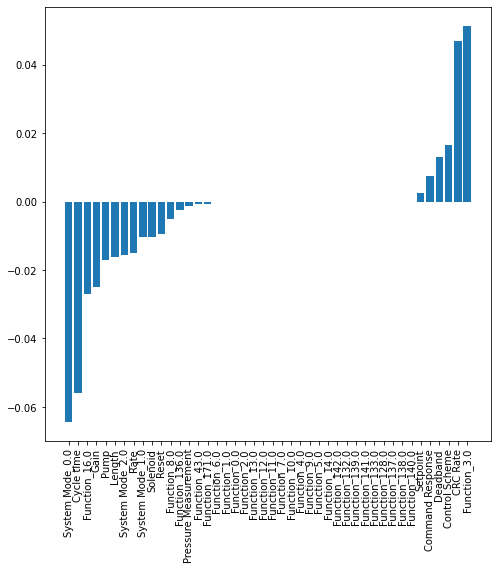

In [ ]:
shap_list = []

for i in range(len(shap_values[1][0])):
  shap_list.append([test.columns[i], shap_values[1][0][i]])

shap_list.sort(key = lambda x: x[1])
print(shap_list)

x = []
y = []
for k in shap_list:
  x.append(k[0])
  y.append(k[1])

plt.figure(figsize=(8,8))
plt.xticks(rotation=90)
plt.bar(x,y)

# Rule Based Learning models


## JRipper

In [ ]:
# Creating a Custom class for the JRipper classifier (To make it compatable with standard python libraries)

import wittgenstein as lw

class Ripper(BaseEstimator, ClassifierMixin):

  def __init__(self, class_type):
    self.clf = lw.RIPPER()
    self.pos_class = class_type
  
  def __call__(self, data):
    return self.clf.predict(data)

  def fit(self, data, size):
    self.dummy_ = "dummy"
    self.classes_ = ['Normal', 'Anamoly']
    self.clf.fit(data.sample(size), class_feat = 'Binary Result', pos_class=self.pos_class)
    return self
  
  def predict(self, data):
    yc_pred = self.clf.predict(data)

    if(self.pos_class==1.0):
      y_pred = [1 if i==True else 0 for i in yc_pred]
    else:
      y_pred = [0 if i==True else 1 for i in yc_pred] 
    return np.array(y_pred).astype('float')
  
  def predict_proba(self, data):
    y = self.predict(data)
    y_final = []
    for i in y:
      y_final.append([i, 1-i])

    return np.array(y_final).astype('float32')
  
  def get_rules(self):
    print("\nRules of the JRIPPER Classifier: ")
    rules = self.clf.ruleset_.out_pretty()
    print(rules)


rip = Ripper(0.0)
rip.fit(train, 20000)
y_pred = rip.predict(test)
performance(test['Binary Result'], y_pred)
rip.get_rules()

[[ 5232 37698]
 [   59 11937]]
              precision    recall  f1-score   support

         0.0    0.98885   0.12187   0.21700     42930
         1.0    0.24050   0.99508   0.38737     11996

    accuracy                        0.31258     54926
   macro avg    0.61467   0.55848   0.30219     54926
weighted avg    0.82541   0.31258   0.25421     54926


Rules of the JRIPPER Classifier: 
[[Length=-0.8238566394983673 ^ Function_3.0=1.0] V
[Function_16.0=1.0 ^ SystemMode_0.0=1.0 ^ Rate=-0.14--0.14 ^ Cycletime=0.49-0.61 ^ Gain=-0.12-0.0 ^ ControlScheme=1.0 ^ Deadband=0.07-0.53] V
[Function_16.0=1.0 ^ SystemMode_0.0=1.0 ^ Rate=-0.14--0.14 ^ Cycletime=0.49-0.61 ^ Setpoint=-0.64--0.31 ^ Deadband=0.88-1.34] V
[Function_16.0=1.0 ^ SystemMode_0.0=1.0 ^ Rate=-0.14--0.14 ^ Cycletime=0.49-0.61 ^ Gain=0.0-0.23 ^ Pump=1.0] V
[Function_16.0=1.0 ^ SystemMode_0.0=1.0 ^ Rate=-0.14--0.14 ^ Cycletime=-0.51--0.43 ^ Pump=0.0 ^ Solenoid=1.0 ^ Setpoint=0.67-1.0] V
[Function_16.0=1.0 ^ SystemMode_0.0=1.0 ^ R

Currently plotting Pressure Measurement


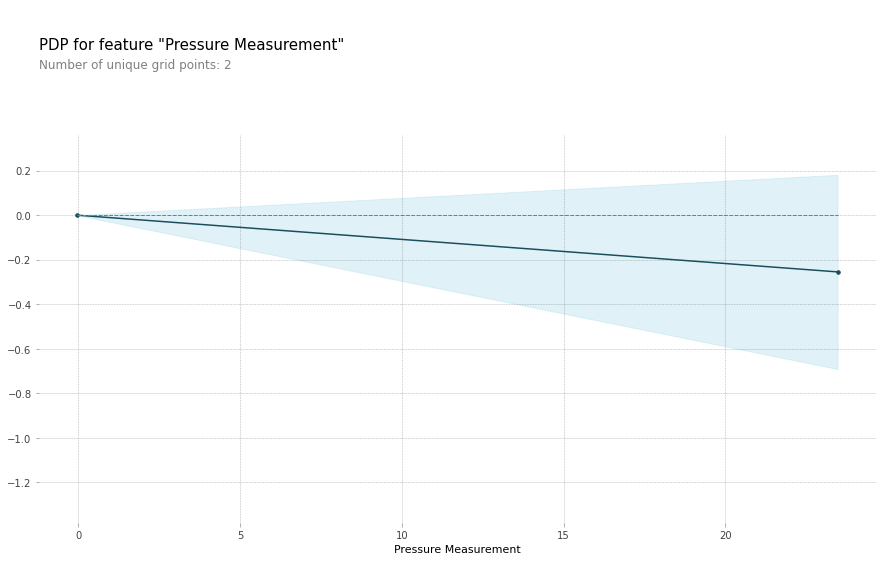

-------------------------------------------
[[-0.05362004742351883, 23.93981638800429]]


In [ ]:
# Get the PDP plots for and feature from which the interval can be extracted

from sklearn.inspection import partial_dependence
feature = ['Pressure Measurement']
pdp, axes = partial_dependence(rip, test.sample(10000).drop(['Binary Result'], axis=1), feature, percentiles=(0,1))
plot_pdp(rip, test.sample(1000), feature)
pdp = pdp[0]
axes = axes[0]

interval = []
flag=0
start = 0
end = 0

for i in range(len(pdp)):
  if((pdp[i]-pdp[0]) != 0):
    if(flag==0):
      flag = 1
      start = i
  elif(flag==1):
    flag=0
    interval.append([axes[start], axes[i-1]])

if(flag==1):
  interval.append([axes[start], axes[len(pdp)-1]])
print(interval)

In [ ]:
# Get the shap values for each data point to know which features can be attacked

def inter(d):
  d = pd.DataFrame(d)
  d.columns = names
  return rip.predict(d)

ch = train.sample(100)
shap.initjs()
ex = shap.KernelExplainer(inter, ch.drop(['Binary Result'], axis=1))
shap_values = ex.shap_values(cc.iloc[:,:-1])
shap.force_plot(ex.expected_value, shap_values, cc.iloc[:,:-1])

In [ ]:
# JRipper Classifier to learn the attack datapoints and normal datapoints (Using an ensemble)

# rip0 = Ripper(0.0)
# rip0.fit(train,20000)
# rip1 = Ripper(1.0)
# rip1.fit(train,20000)
# y0 = rip0.predict(test)
# y1 = rip1.predict(test)
# y_pred = np.zeros((len(y0),))
# for i in range(len(y1)):
#   if(y0[i]==1.0 and y1[i]==1.0):
#     y_pred[i]=1.0

# performance(test['Binary Result'], y_pred)

In [ ]:
## The performance is still not good enough ----> Recall for the individual classifeirs is very bad hence even in separate classes performance is not good enough

# cat_classes = 7
# l = 0.0
# y_final = []
# for i in range(0,cat_classes):
#   print(i)
#   df = train.copy(deep = True)
#   if(i>0):
#     l = 1.0
#   else:
#     l = 0.0
  
#   for j in range(len(df)):
#     if(ctrain.iloc[j]==i):
#       df.iloc[j]['Binary Result'] = l
#     else:
#       df.iloc[j]['Binary Result'] = 1-l
  
#   print(Counter(df['Binary Result']))
#   rip = Ripper(l)
#   rip.fit(df.iloc[:,:-1], 20000)
#   y_pred = rip.predict(test)
#   performance(test['Binary Result'], y_pred)
#   y_final.append(y_pred)

## Direct Rules

In [11]:
# Custom classifier for direct rule based analysis

class DirectRule(BaseEstimator, ClassifierMixin):

  def fit(self, data):
    self.dummy_ = "dummy"
    self.classes_ = ['Normal', 'Anamoly']
    return self

  def predict(self, data):
    y_pred = []
    for i in range(0,data.shape[0]):
      cond1 = (data.iloc[i]['CRC Rate'] > ((14000-crc_mean)/crc_std)) and (data.iloc[i]['Command Response'] == 1)
      cond2 = data.iloc[i]['CRC Rate'] > ((16000-crc_mean)/crc_std)
      cond3 = (data.iloc[i]['Function_43.0']== 1) or (data.iloc[i]['Function_128.0']== 1) or (data.iloc[i]['Function_132.0']== 1) or (data.iloc[i]['Function_133.0']== 1) or (data.iloc[i]['Function_136.0']== 1) or (data.iloc[i]['Function_137.0']== 1) or (data.iloc[i]['Function_138.0']== 1) or (data.iloc[i]['Function_139.0']== 1) or (data.iloc[i]['Function_140.0']== 1) or (data.iloc[i]['Function_141.0']== 1) or (data.iloc[i]['Function_142.0']== 1) or (data.iloc[i]['Function_171.0']== 1) 

      if(cond1 or cond2 or cond3):
        y_pred.append('1')
      else:
        y_pred.append('0')

    return np.array(y_pred).astype('float')

  def predict_proba(self, data):
    y = self.predict(data)
    y_final = []
    for i in y:
      y_final.append([i, 1-i])

    return np.array(y_final).astype('float32')

dr = DirectRule()
dr.fit(train)
y_pred = dr.predict(test)
performance(test['Binary Result'], y_pred)

# imp = get_importances(dr, test, 'Binary Result')
# plot_pdp(dr, test, imp)


[[24198 18732]
 [ 4179  7817]]
              precision    recall  f1-score   support

           0    0.85273   0.56366   0.67870     42930
           1    0.29444   0.65163   0.40560     11996

    accuracy                        0.58288     54926
   macro avg    0.57358   0.60765   0.54215     54926
weighted avg    0.73080   0.58288   0.61905     54926



In [ ]:
from sklearn.inspection import partial_dependence
feature = ['CRC Rate']
pdp, axes = partial_dependence(dr, test.iloc[:,:-1].sample(10000), feature, percentiles=(0,1))
plot_pdp(rf, test.iloc[:,:-1].sample(10000), feature)
pdp = pdp[0]
axes = axes[0]

interval = []
flag=0
start = 0
end = 0

for i in range(len(pdp)):
  if((pdp[i]-pdp[0]) != 0):
    if(flag==0):
      flag = 1
      start = i
  elif(flag==1):
    flag=0
    interval.append([axes[start], axes[i-1]])

if(flag==1):
  interval.append([axes[start], axes[len(pdp)-1]])
print(interval)

# Deep Learning Models

In [ ]:
# Used to verify the performance obatined and just to compare that I haven't done anything wrong

# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

# input = Input(shape=[44], name='input')
# d1 = Dense(500, activation='relu', name='dense1')(input)
# dr1 = Dropout(0.2, name='dropout1')(d1)
# d2 = Dense(300, activation='relu',  name='dense2')(dr1)
# dr2 = Dropout(0.2, name='dropout2')(d2)
# d3  = Dense(100, activation='relu', name='dense3')(dr2)
# dr3 = Dropout(0.2, name='dropout3')(d3)
# d4  = Dense(10, activation='relu', name='dense4')(dr3)
# output = Dense(1, activation='sigmoid', name='output')(d4)

# model = tf.keras.Model(inputs = input, outputs = output)
# model.summary()

# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# X_train, X_test, y_train, y_test = ds

# history = model.fit(X_train, y_train, batch_size = 256, validation_data= (X_test, y_test), epochs=500)

In [ ]:
class ModelNN(nn.Module):
  def __init__(self):
    super(ModelNN, self).__init__()
    self.dp = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(44,500)
    self.fc2 = nn.Linear(500,300)
    self.fc3 = nn.Linear(300,100)
    self.fc4 = nn.Linear(100,10)
    self.fc5 = nn.Linear(10,1)  
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = self.dp(x)
    x = torch.relu(self.fc2(x))
    x = self.dp(x)
    x = torch.relu(self.fc3(x))
    x = self.dp(x)
    x = torch.relu(self.fc4(x))
    x = torch.sigmoid(self.fc5(x))
    return x

In [ ]:
## Creating the train and test datasets 

trainx = torch.from_numpy(ds[0]).type(torch.float)
trainy = torch.from_numpy(ds[2]).type(torch.float)#.unsqueeze(1)
testx = torch.from_numpy(ds[1]).type(torch.float)
testy = torch.from_numpy(ds[3]).type(torch.float)#.unsqueeze(1)

train_data = TensorDataset(trainx, trainy)
test_data = TensorDataset(testx, testy)

train_dataloader = DataLoader(train_data, shuffle = True, batch_size = 512)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = 512)

## Building the DNN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using the device: " + device)

Using the device: cpu


In [ ]:
model = ModelNN().to(device)

## Training and testing phases

epochs = 300
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)
train_acc = []
train_loss = []
test_acc = []
test_loss = []

for ep in range(epochs):
  print("---------------------------------------------------")
  print(f"Epoch Number {ep}")
  correct = 0
  total = 0
  for phase in ['train', 'validate']:

    if(phase=='train'):
      model.train(True)
      loader = train_dataloader
    elif(phase=='validate'):
      model.train(False)
      loader = test_dataloader

    for batch, (X, y) in enumerate(loader):
      # if(batch%100==0):
      #   print(f"Handing batch number: {batch} in phase {phase}")
      X = X.to(device)
      y = y.to(device)

      y_pred = model(X).squeeze()
      loss = loss_fn(y_pred, y)

      if(phase=='train'):
        optim.zero_grad()
        loss.backward()
        optim.step()
        y_pred = ((y_pred > 0.5)*1.0)
        correct += (y_pred==y).sum()
        total += len(y)

      elif(phase=='validate'):
        y_pred = ((y_pred > 0.5)*1.0)
        #print(f"Testing Loss = {loss_fn(y_pred, y)}")
        correct += (y_pred==y).sum()
        total += len(y)

    acc = 100 * (correct/total)
    if(phase=='validate'): 
      test_acc.append(acc.item())
      test_loss.append(loss.item())
      print(f"Accuracy of the validation set {acc}")
    elif(phase=='train'):
      train_acc.append(acc.item())
      train_loss.append(loss.item())
      print(f"Accuracy of the train set {acc}")

---------------------------------------------------
Epoch Number 0
Accuracy of the train set 84.23819732666016
Accuracy of the validation set 84.74299621582031
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 87.27503204345703
Accuracy of the validation set 87.41133880615234
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 87.94503021240234
Accuracy of the validation set 87.96808624267578
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 88.10797882080078
Accuracy of the validation set 88.18766021728516
---------------------------------------------------
Epoch Number 4
Accuracy of the train set 88.23406219482422
Accuracy of the validation set 88.24518585205078
---------------------------------------------------
Epoch Number 5
Accuracy of the train set 88.32600402832031
Accuracy of the validation set 88.3686294555664
-----------------------------------------

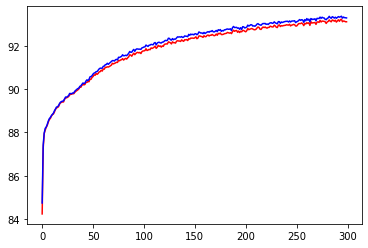

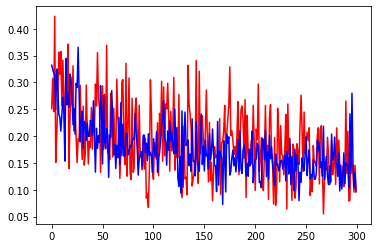

In [ ]:
x = np.arange(0,len(train_acc))

plt.plot(x, train_acc, c='r')
plt.plot(x, test_acc, c='b')
plt.show()

plt.plot(x, train_loss, c='r')
plt.plot(x, test_loss, c='b')
plt.show()

In [ ]:
torch.save(model.state_dict() ,'bestmodel_dnn_altered.pk')

# Adversarial Attacks on Deep Learning Models

In [ ]:
# Loading the trained Model

model = ModelNN()
model.load_state_dict(torch.load('bestmodel_dnn_altered.pk', map_location=torch.device('cpu')))
model.to(device)
print(model.eval())

ypred = model(testx.to(device))
ypred = (ypred > 0.5)*1.0
print(classification_report(testy.to('cpu').numpy(), ypred.to('cpu').numpy()))
print(confusion_matrix(testy.to('cpu').numpy(), ypred.to('cpu').numpy()))

ModelNN(
  (dp): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=44, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     42906
         1.0       0.91      0.89      0.90     12020

    accuracy                           0.96     54926
   macro avg       0.94      0.93      0.94     54926
weighted avg       0.96      0.96      0.96     54926

[[41896  1010]
 [ 1290 10730]]


In [ ]:
# Direct FGSM attack (verifying the possibility of a basic attack)

loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)

def FGSM(X, data_grad, epsilon):
  perturbed_sample = X + epsilon * data_grad.sign()
  return perturbed_sample

def attack(test_data, epsilon):
  correct = 0
  adversarial_examples = []
  for X, target in test_data:
    X, target = X.to(device), target.to(device)  
    X.requires_grad = True

    y_pred = model(X).squeeze()
    y_pred_class = 1.0 * (y_pred > 0.5)

    # Already predicted wrongly
    if(y_pred_class.item() != target.item()):
      continue

    loss = loss_fn(y_pred, target)
    optim.zero_grad()
    loss.backward()
    data_grad = X.grad.data

    adversarial_sample = FGSM(X, data_grad, epsilon)

    output = model(adversarial_sample)
    output = 1.0 * (output > 0.5)

    if(output.item() == target.item()):
      correct += 1
    else:
      adversarial_examples.append([output.item(), target.item(), adversarial_sample])

  acc = correct/len(test_data)
  print(f"Accuracy after adversarial attacks {acc}")
  return acc, adversarial_examples

ad_acc = []
eps = []
for ep in np.arange(0,0.501, 0.05):
  acc, adversarial_examples = attack(test_data, ep)
  eps.append(ep)
  ad_acc.append(acc)

plt.plot(np.array(eps), np.array(ad_acc))
plt.show()

acc, adversarial_sample = attack(test_data, 0.1)

In [ ]:
# White box attacks
def get_wb_data_grad(model, perturbed_image, target, loss_fn, optim):
  
  perturbed_image.requires_grad = True
  y_pred = model(perturbed_image).squeeze()
  y_pred_class = 1.0 * (y_pred > 0.5)

  loss = loss_fn(y_pred, target)
  optim.zero_grad()
  loss.backward()
  data_grad = perturbed_image.grad.data

  return data_grad

def fx(model, x):
  p1 = model(x).to(device)
  p0 = 1.0 - p1
  p0 = p0.to(device)

  return (torch.log(p1) - torch.log(p0)).to(device)
  #return torch.max(torch.log(p1) - torch.log(p0), torch.Tensor([-0.1]).to(device))

# Black box attacks
def get_bb_data_grad(model, perturbed_image, target):
  data_grad = []
  for i in range(44):
    temp1 = perturbed_image.clone()
    temp2 = perturbed_image.clone()
    temp1[i] = temp1[i] + 0.01
    temp2[i] = temp2[i] - 0.01

    #data_grad.append((model(temp2)-model(temp1))/0.02)
    data_grad.append((fx(model, temp2) - fx(model, temp1))/0.02)
    
  return torch.Tensor(data_grad)

In [ ]:
# Helper function to ensure that the gradients computed by the ZOO model matches the white box attacks

# def calc_grad_match():
#   attack_labels = [[1,2]]#, [3,4], [5,6], [7,8], [9,10], [11, 12], [13, 13], [14, 14], [15, 15], [18, 18], [21,21], [25, 26], [27,28], [29,30,31],[32,32], [33,34],[35,35]]
#   loss_fn = nn.BCELoss()
#   optim = torch.optim.Adam(model.parameters(),lr=0.001)
#   count = []
#   cur = []
#   matches = []

#   for j in range(len(attack_labels)):
#     data = get_attack_data(attack_labels[j])
#     cur = []
#     for x, y in data:
#       print("***")
#       x = x.to(device)
#       y = y.to(device)
#       d1 = get_wb_data_grad(model, x, y, loss_fn, optim)
#       d2 = get_bb_data_grad(model, x, y).to(device)

#       d1v, d1i = torch.topk(torch.abs(d1), 10)
#       d2v, d2i = torch.topk(torch.abs(d2), 10)
#       print(d1i[0:3], d2i[0:3])
#       #count.append(torch.sum(1.0 * (d1.sign() == d2.sign() )).item())
#       mm = 0
#       for i in range(0,10):
#         if(d1i[i]==d2i[i]):
#           mm += 1
#         else:
#           break
#       #count.append(torch.sum(1.0 * (d1i == d2i)).item())
#       cur.append(mm)
    
#     cc = Counter(cur)
#     vv = 0
#     for i in range(5,11):
#       vv += cc[i]

#     print(vv, len(data), vv/len(data))
#     matches.append(vv/len(data))
#   print(Counter(count))

#   return matches

# calc_grad_match()

# With -0.1 as extra
# Counter({3.0: 6716, 1.0: 1350, 0.0: 1182, 2.0: 733})

# No -0.1
# Counter({3.0: 7283, 1.0: 1333, 2.0: 885, 0.0: 480})
# Counter({5.0: 8632, 3.0: 512, 2.0: 237, 4.0: 215, 1.0: 199, 0.0: 186}) ==> 0.001
# Counter({5.0: 8668, 3.0: 380, 0.0: 340, 1.0: 239, 2.0: 190, 4.0: 164}) ===> 0.0001

# No log direct method
# Counter({3.0: 7276, 1.0: 1313, 2.0: 900, 0.0: 492})

# con_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# bin_features = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

# data = get_attack_data([1,2])
# X, target = data[5]
# X = X.to(device)
# target = target.to(device)
# print(X)
# pp = CD(model, X, target, [1], 0.1, [], 1.0, 5, 20, bin_features, con_features)
# print(pp[0])
# pp = pp[3]
# d2v, d2i = torch.topk(torch.abs(pp), 10)
# print(d2i[0:3])

# ll = get_bb_data_grad(model, X, target)
# print(ll)
# d2v, d2i = torch.topk(torch.abs(ll), 10)
# print(d2i[0:3])


# loss_fn = nn.BCELoss()
# optim = torch.optim.Adam(model.parameters(),lr=0.001)
# ll = get_wb_data_grad(model, X, target, loss_fn, optim)
# print(ll)
# d2v, d2i = torch.topk(torch.abs(ll), 10)
# print(d2i[0:3])

In [ ]:
# Coordinated descent algorithm to generate an adversarial sample from a given data point

def CD(model, X, target, attack_features, epsilon, importance, bb, bin_limit, con_limit, binary_features, continous_features):
  '''
  model: Trained DNN IDS model
  X: Attack datapoint that have to be adversarially modified
  target: attack class
  attack_feature: feature currently under attack (should remain unmodified)
  epsilon: magnitude of perturbation
  bb: black box or white box
  bin_limit: limit on the number of times a binary feature can be manipulated
  con_limit: limit on the number of times a continuous feature can be manipulated
  binary_features: list of binary features
  continous_features: list of continuous features
  '''

  X = X.to(device)
  target = target.to(device)

  if(model(X).squeeze().item() == 1.0):
    return 'Zerograd', 0, 0, X, []
  if(1.0 * (model(X).squeeze() > 0.5) == 0.0):
    return 'misclassified', 0, 0, X, []

  # Number of time the binary and continuous feature have been modified in this iterataion
  con_change = 0
  bin_change = 0

  perturbed_image = X
  flag=1
  change = [] # features that have been modified

  while(1.0 * (model(perturbed_image).squeeze() > 0.5) == target):

    if(bb==1.0): # black box attack
      data_grad = get_bb_data_grad(model, perturbed_image, target)
    else: # white box attack
      loss_fn = nn.BCELoss()
      optim = torch.optim.Adam(model.parameters(),lr=0.001)
      data_grad = get_wb_data_grad(model, perturbed_image, target, loss_fn, optim)

    #kk = torch.tensor(importance).to(device)
    #kk = torch.ones(44,).to(device) - torch.tensor(importance).to(device)

    data_grad_abs = data_grad.clone().to(device)
    data_grad_abs = torch.abs(data_grad).to(device) #* kk.to(device)

    #data_grad = data_grad * torch.tensor(importance).to(device)

    # Get the top features that are not in attack right now
    top_values, top_indices = torch.topk(data_grad_abs, 44)
    copy = perturbed_image
    perturbed_image.requires_grad = False
    top_indices = top_indices.to('cpu').numpy()
    flag=0
    for ind in top_indices:

      if(ind not in attack_features): # attack feature should remain unchanged

        #print(ind, data_grad[ind].item())  
        if(ind in continous_features and con_change < con_limit): # if continous directly modify
          change.append(ind)

          perturbed_image[ind] = perturbed_image[ind] + epsilon * data_grad.sign()[ind]  
          con_change += 1
          flag=1
          break

        elif(data_grad.sign()[ind] > 0 and perturbed_image[ind] < 1 and bin_change < bin_limit): # if binary multiple constraints need to be fulfilled
          #print(data_grad[13:41])
          temp = perturbed_image.clone()

          # One hot encoded variables
          # 13 - 41 ===> Function Code
          # 41 - 44 ===> System Mode
          if(ind.item() < 41 and ind.item() >= 13):
            high = 13 + torch.argmax(perturbed_image[13:41])
            temp[high]=0
            temp[ind]=1
          elif(ind.item() < 44 and ind.item() >= 41):
            high = 41 + torch.argmax(perturbed_image[41:44])
            temp[high]=0
            temp[ind]=1
          else:
            continue
   
          # Binary update 0-->1 or 1-->0
          if(model(temp) - model(perturbed_image) < 0):
            #print("Updating Binary variable")
            perturbed_image = temp
            change.append(ind)
            #change.append(high)
            bin_change += 1
            flag=1
            break

    if(flag==0):
      break
          

        # elif(data_grad.sign()[ind] < 0 and perturbed_image[ind] > 0):
        #   perturbed_image[ind] = 0
        #   change.append(ind)
        #   bin_change += 1
        #   flag=1
        #   break

        # elif(data_grad.sign()[ind] > 0 and perturbed_image[ind] < 1):
        #   perturbed_image[ind] = 1
        #   if((model(copy)-model(perturbed_image)) > 0):
        #     change.append(ind)
        #     bin_change += 1
        #     flag=1
        #     break
        #   else:
        #     perturbed_image[ind] = 0
        #     continue
          

        # elif(data_grad.sign()[ind] < 0 and perturbed_image[ind] > 0):
        #   perturbed_image[ind] = 0
        #   if((model(copy)-model(perturbed_image)) > 0):
        #     change.append(ind)
        #     bin_change += 1
        #     flag=1
        #     break
        #   else:
        #     perturbed_image[ind] = 1
        #     continue

  if(1.0 * (model(perturbed_image).squeeze() > 0.5) == 1.0):
    return 'Failed', con_change, bin_change, perturbed_image, change

  #print(con_change, bin_change, model(perturbed_image).squeeze().item())
  #print(torch.sub(X,perturbed_image))
  return 'Done', con_change, bin_change, perturbed_image, change
  


In [ ]:
# Function to generate adversarial attack for each attack class

def calculate_adver(model, only_attack_data, attack_index, epsilon, imp, bb, bin_cond, con_cond, bin_features, con_features):
  '''
  model: Trained DNN IDS model
  X: Attack datapoint that have to be adversarially modified
  only_attack_data: dataset of attack points of a specific attack
  attack_index: feature currently under attack
  epsilon: magnitude of perturbation
  imp: Importance of various features [Not used]
  bb: black box or white box
  bin_cond: limit on the number of times a binary feature can be manipulated
  con_cond: limit on the number of times a continuous feature can be manipulated
  binary_features: list of binary features
  continous_features: list of continuous features
  '''
  correct = 0
  zero_grad = 0
  failed = 0
  misclassified = 0
  diff = []
  succ = []
  var = []
  change = []

  for er, [x, y] in enumerate(only_attack_data):

    original = x.clone()

    p, q, r, s, t = CD(model, x, y, attack_index, epsilon, imp, bb, bin_cond, con_cond, bin_features, con_features)
  '''
  p: result of the analysis
  q: number of updates in continous features
  r: number of updates in continous features
  s: adversarial_image
  t: features that were modified
  '''   
    if(p=='Zerograd'): # strong prediction 0/1
      zero_grad += 1
      #print("Zerograd")

    elif(p=='misclassified'): # already misclassified
      misclassified += 1
      #print("misclassified")

    elif(p=='Failed'): # failed to create an adversarial sample
      failed += 1
      #print("Failed")

    else: # Successfully created an adversarial sample
      change.append(torch.sub(original.to(device),s).to('cpu').numpy())

      diff.append([r,q])
      #diff.append(t)
      succ.append(s)
      
      for m in t:
        var.append(m)

      correct += 1
      #print(f"Done {correct}  {q}  {r}")
    

  return [correct, succ, failed, diff, var, change, misclassified, zero_grad]

In [ ]:
# We only consider attack data points and make sure that it can pass through the IDS undetected

def get_attack_data(labels):  
  
  test = pd.DataFrame(ds[1])
  test.columns = names[:-1]
  test['Specific Result'] = ytec
  test

  only_attack = test[test['Specific Result'].isin(labels)]
  target_attack = np.ones(len(only_attack),)

  only_attack = torch.from_numpy(np.array(only_attack.iloc[:,:-1]).astype('float32')).type(torch.float)
  target_attack = torch.from_numpy(np.array(target_attack).astype('float32')).type(torch.float)#.unsqueeze(1)

  only_attack_data = TensorDataset(only_attack, target_attack)

  # only_attack = model(only_attack.to(device))
  # only_attack = only_attack.detach().to('cpu').numpy()
  # only_attack = only_attack.reshape(-1)
  # perfect1_count = Counter(only_attack)
  #print(len(only_attack) - perfect1_count[0] - perfect1_count[1], perfect1_count[1]/len(data))

  return only_attack_data

In [ ]:
# Helper function to analyse the output of the adversarial algorithm

def process_merged(merged):
  c = 0
  f = 0
  m = 0
  z = 0
  v = []
  d = []

  for i in merged:
    c += i[0]
    f += i[2]
    m += i[6]
    z += i[7]

    for a,b in i[3]:
      v.append(a+b)
    
    for a in i[5]:
      d.append(np.sum(np.abs(a)))

  plt.hist(d, bins=50, density = True, stacked = True)
  plt.show()

  n = c + f + m + z + 0.00001
  print(f"Correct : {c/n}   Failed: {f/n}   Mis: {m/n}  Zero: {z/n} Total: {n}")
  print(f"Percentage of adversarial examples generated = {c/(c+f+0.00001)}")
  print(f"Total number of adversarial examples = {c}")
  print(f"Average number of features modified per sample {np.sum(v)/len(v)}")
  print(f"Average change per sample {np.sum(d)/len(d)}")

  per = c/(c+f+0.00001)
  avg = np.sum(v)/len(v)
  change = np.sum(d)/len(d)

  return per, avg, change


In [ ]:
# Function that gets the datapoint for each attack class individually and calls the adversarial attack function 
# Also assigns the parameters for the model

def iter(model, epsilon, imp, bb, bin_cond, con_cond):
  start = time.time()
  merged = []
  attack_labels = [[1,2], [3,4], [5,6], [7,8], [9,10], [11, 12], [13, 13], [14, 14], [15, 15], [18, 18], [21,21], [25, 26], [27,28], [29,30,31],[32,32], [33,34],[35,35]]
  do_not_attack = [[1], [2], [3], [6], [4], [5], [10], [11], [41, 42, 43], [8], np.arange(13,41), [7], [7], [7], [7], [1], [1]]
  con_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
  bin_features = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

  # if(len(imp)==0):
  #   print("Not using importance", end=" ")
  # else:
  #   print("Using importance", end=" ")

  # if(bb==1.0):
  #   print("Using Black Box")
  # else:
  #   print("Using White Box")

  if(len(imp)==0):
    imp = torch.ones(44,).to(device)

  for j in range(len(attack_labels)):
    data = get_attack_data(attack_labels[j])
    #print(len(data))
    merged.append(calculate_adver(model, data, do_not_attack[j], epsilon, imp, bb, bin_cond, con_cond, bin_features, con_features))

    #process_merged(merged)
    print("-----------------------------------------------------------")
  print(f"Time taken per iteration {time.time()-start}")

  return merged

In [ ]:
# Tradeoff epsilon vs Limit on Continuous variable change

to = []
for ep in [0.01, 0.05, 0.1, 0.15, 0.2]:
  for jj in [0.5, 1, 1.5, 2, 2.5]:
    cc = int(jj/ep)

    print("-------------------------------")
    print(f"Epsilon: {ep} and Con_limit: {cc}")
    res = iter(model, ep, [], 0.0, 5, cc)
    to.append([process_merged(res)])
    print("-------------------------------")

-------------------------------
Epsilon: 0.01 and Con_limit: 50
#######################################################
Not using importance Using White Box


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time taken per iteration 302.1106011867523
Percentage of adversarial examples generated = 0.909944089456869
Total number of adversarial examples = 4557
Average number of features modified per sample 20.055299539170505
Average change per sample 1.1501578958196181
-------------------------------
-------------------------------
Epsilon: 0.01 and Con_limit: 100
#######################################################
Not using importance Using White Box
Time taken per iteration 359.01021361351013
Percentage of adversarial examples generated = 0.9696485623003195
Total number of adversarial examples = 4856
Average number of features modified per sample 25.424217462932454
Average change per sample 1.056614380888334
-------------------------------
-------------------------------
Epsilon: 0.01 and Con_limit: 150
#######################################################
Not using importance Using White Box
Time taken per iteration 382.35305166244507
Percentage of adversarial examples generated = 0.

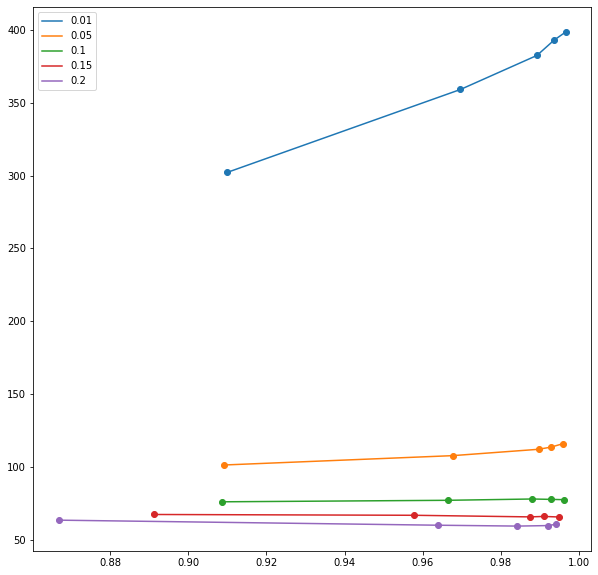

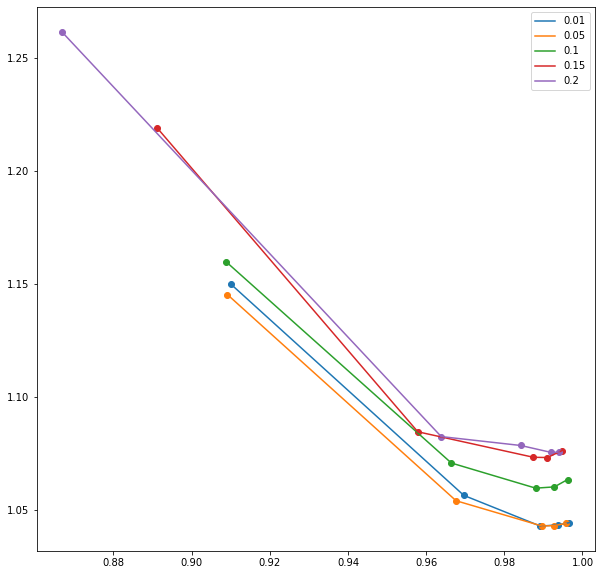

In [ ]:
# Analysing the results of the trade-off

px = [i[0][0] for i in to]
py = [i[0][1] for i in to]
pz = [i[0][2] for i in to]
pz = np.array(pz)
tt = [302.11, 359.01, 382.35, 392.87, 398.48, 101.47, 107.88, 112.24, 113.73, 116.03, 76.23, 77.26, 78.15, 77.89, 77.68, 67.53, 66.98, 65.88, 66.19, 65.81, 63.64, 60.17, 59.57, 59.92, 60.78]
tt = np.array(tt)
epp =[0.01, 0.05, 0.1, 0.15, 0.2]
# plt.figure(figsize=(10,10))
# for i in range(5):
#   l = str(epp[i])
#   plt.plot(px[i*5:(i+1)*5], py[i*5:(i+1)*5], label=l)
#   plt.scatter(px[i*5:(i+1)*5], py[i*5:(i+1)*5])

# plt.legend()
# plt.show()


# Accuracy vs Time taken
plt.figure(figsize=(10,10))
for i in range(5):
  l = str(epp[i])
  plt.plot(px[i*5:(i+1)*5], tt[i*5:(i+1)*5], label=l)
  plt.scatter(px[i*5:(i+1)*5], tt[i*5:(i+1)*5])

plt.legend()
plt.show()


# Accuracy vs avg change in image
plt.figure(figsize=(10,10))
for i in range(5):
  l = str(epp[i])
  plt.plot(px[i*5:(i+1)*5], pz[i*5:(i+1)*5], label=l)
  plt.scatter(px[i*5:(i+1)*5], pz[i*5:(i+1)*5])

plt.legend()
plt.show()


In [ ]:
import pickle
pickle.dump(to, open('to.pkl','wb'))

In [ ]:
import pickle
to = pickle.load(open('to.pkl','rb'))

In [ ]:
# class base_clf(BaseEstimator, ClassifierMixin):

#   def __init__(self, classifier):
#     self.clf = classifier
  
#   def __call__(self, data):
#     x = data.clone().cpu().detach().numpy().reshape(1,-1)
#     y = self.clf.predict_proba(x)
#     z = [i[1] for i in y]
#     z = np.array(z)
#     z = z.reshape(len(z),1)
#     return torch.Tensor(z).to(device)

# c1 = base_clf(rf)

-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
----------------------------------------

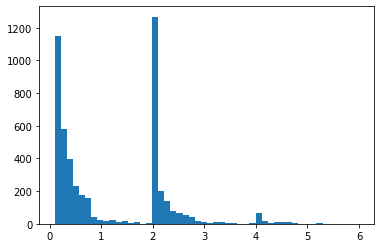

Correct : 0.49379977770561573   Failed: 0.01723964107547168   Mis: 0.12985179944565803  Zero: 0.35910878076508845 Total: 9919.00001
Percentage of adversarial examples generated = 0.9662655337023762
Total number of adversarial examples = 4898
Average number of features modified per sample 3.71396488362597
Average change per sample 1.1654961408036444
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-------------------------------------------------

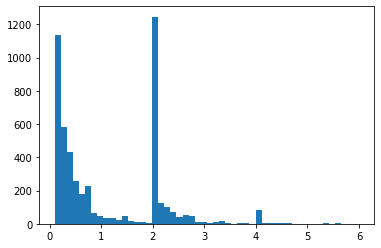

Correct : 0.5022683733216369   Failed: 0.008771045459450504   Mis: 0.12985179944565803  Zero: 0.35910878076508845 Total: 9919.00001
Percentage of adversarial examples generated = 0.9828368495110735
Total number of adversarial examples = 4982
Average number of features modified per sample 3.7731834604576475
Average change per sample 1.1183862490904757


(0.9828368495110735, 3.7731834604576475, 1.1183862490904757)

In [ ]:
# Running white and black box attacks

bba = iter(model, 0.1, [], 1.0, 5, 20)
process_merged(bba)
wba = iter(model, 0.1, [], 0.0, 5, 20)
process_merged(wba)

In [ ]:
import pickle
pickle.dump(bba, open('bba.pkl','wb'))
pickle.dump(wba, open('wba.pkl','wb'))

In [ ]:
wba = pickle.load(open('wba.pkl','rb'))
bba = pickle.load(open('bba.pkl','rb'))

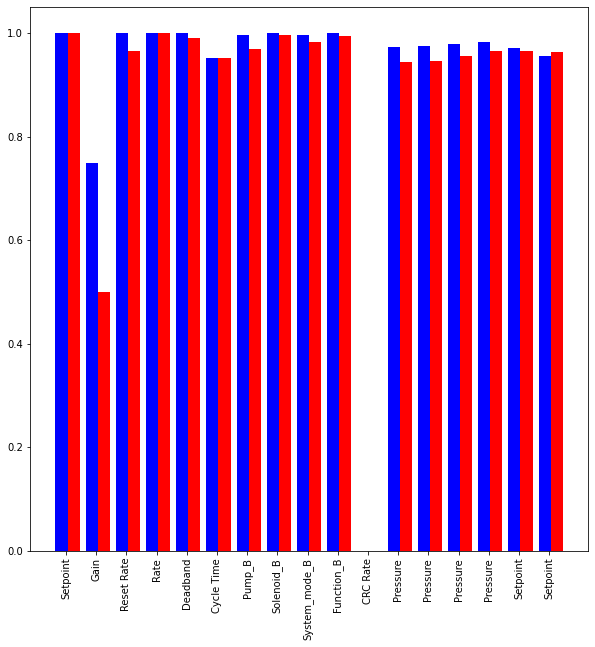

['Length', 'Setpoint', 'Gain', 'Reset', 'Deadband', 'Cycle time', 'Rate', 'Pressure Measurement', 'CRC Rate', 'Control Scheme', 'Pump', 'Solenoid', 'Command Response', 'Function_0.0', 'Function_1.0', 'Function_2.0', 'Function_3.0', 'Function_4.0', 'Function_5.0', 'Function_6.0', 'Function_7.0', 'Function_8.0', 'Function_9.0', 'Function_10.0', 'Function_11.0', 'Function_12.0', 'Function_13.0', 'Function_14.0', 'Function_16.0', 'Function_43.0', 'Function_128.0', 'Function_132.0', 'Function_133.0', 'Function_136.0', 'Function_137.0', 'Function_138.0', 'Function_139.0', 'Function_140.0', 'Function_141.0', 'Function_142.0', 'Function_171.0', 'System Mode_0.0', 'System Mode_1.0', 'System Mode_2.0', 'Binary Result']


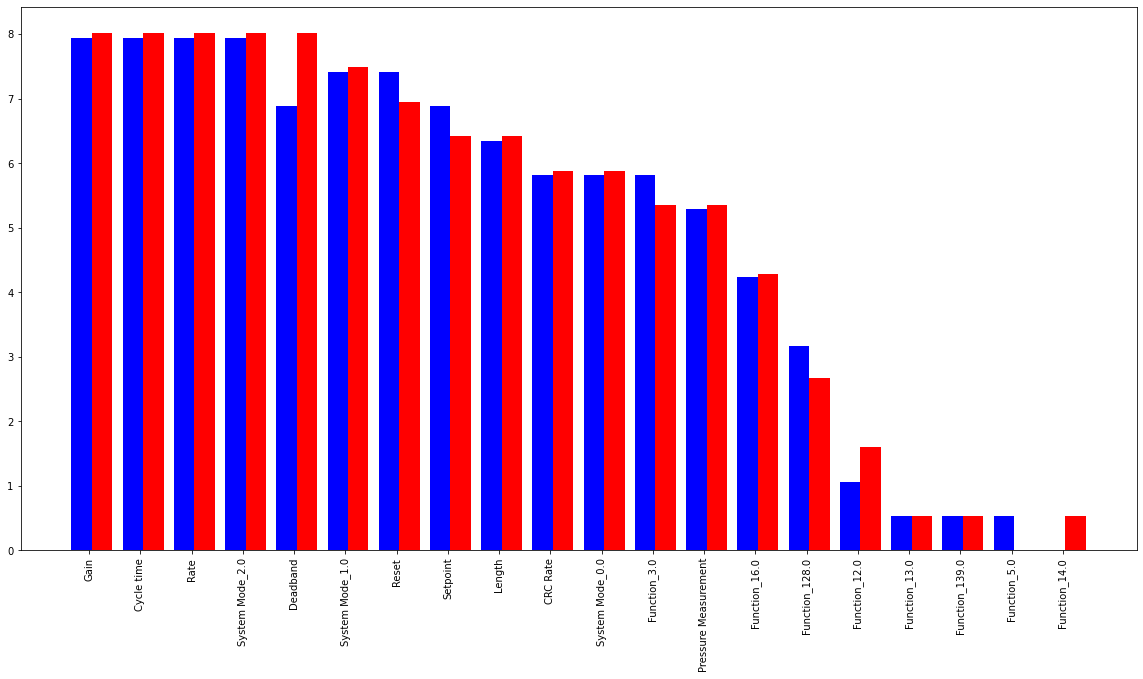

[]


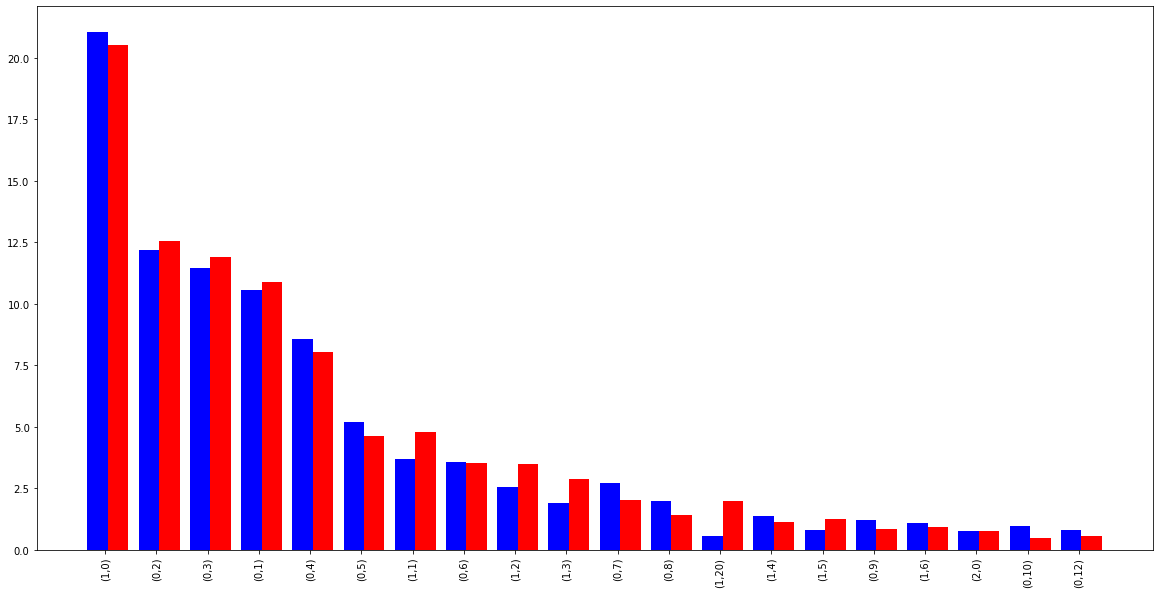

In [ ]:
# Comparing the white and the black box performance

# Performance on various attacks 

q1 = [i[0]/(i[0]+i[2]+0.00001) for i in wba]
q2 = [i[0]/(i[0]+i[2]+0.00001) for i in bba]

xx = np.arange(0,len(q1))
attack_names = ['Setpoint', 'Gain', 'Reset Rate', 'Rate', 'Deadband', 'Cycle Time', 'Pump_B', 'Solenoid_B', 'System_mode_B', 'Function_B', 'CRC Rate', 'Pressure', 'Pressure', 'Pressure', 'Pressure', 'Setpoint', 'Setpoint']

plt.figure(figsize=(10,10))
plt.bar(2*xx,q1,color='blue')
plt.bar(2*xx + 0.8,q2, color='red')
plt.xticks(2*xx + 0.3, attack_names, rotation=90)
plt.show()

# Most used feature for attacks
v1 = []
v2 = []

# Combination used most (binary, continuous)
t1 = []
t2 = []

for i in wba:
  for j in np.unique(i[4]):
    v1.append(j)
  for j in i[3]:
    a,b = j
    st = "(" + str(a) + "," + str(b) + ")"
    t1.append(st)

for i in bba:
  for j in np.unique(i[4]):
    v2.append(j)
  for j in i[3]:
    a,b = j
    st = "(" + str(a) + "," + str(b) + ")"
    t2.append(st)

q1 = [i[0] for i in wba]
q2 = [i[0] for i in bba]
xx = np.arange(0,len(q1))
attack_names = ['Setpoint', 'Gain', 'Reset Rate', 'Rate', 'Deadband', 'Cycle Time', 'Pump_B', 'Solenoid_B', 'System_mode_B', 'Function_B', 'CRC Rate', 'Pressure', 'Pressure', 'Pressure', 'Pressure', 'Setpoint', 'Setpoint']



def plot_counter(c1, c2, n):
  k1 = set(c1.keys())
  k2 = set(c2.keys())

  keys = list(k1.union(k2))
  keys = sorted(keys, key = lambda x: c1[x]+c2[x], reverse = True)
  keys = keys[0:20]
  v1 = []
  v2 = []
  xlabel = []
  print(n)
  for k in keys:
    if(len(n)!=0):
      xlabel.append(n[k])
    else:
      xlabel.append(k)
    v1.append(100 * c1[k]/np.sum(list(c1.values())))
    v2.append(100 * c2[k]/np.sum(list((c2.values()))))  

  plt.figure(figsize=(20,10))
  plt.bar(2 * np.arange(len(xlabel)), v1, color='b')
  plt.bar(2 * np.arange(len(xlabel)) + 0.8, v2, color='r')
  plt.xticks(2 * np.arange(len(xlabel)) + 0.3, xlabel, rotation=90)
  plt.show()

plot_counter(Counter(v1), Counter(v2), names)
plot_counter(Counter(t1), Counter(t2), [])

# Adversarial Defense

## Defensive Distillation

In [ ]:
# Loading the DNN model

wba = pickle.load(open('wba.pkl','rb'))

model = ModelNN()
model.load_state_dict(torch.load('bestmodel_dnn_altered.pk', map_location=torch.device('cpu')))
model.to(device)
print(model.eval())

ypred = model(testx.to(device))
ypred = (ypred > 0.5)*1.0
print(classification_report(testy.to('cpu').numpy(), ypred.to('cpu').numpy()))
print(confusion_matrix(testy.to('cpu').numpy(), ypred.to('cpu').numpy()))

ModelNN(
  (dp): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=44, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     42906
         1.0       0.91      0.89      0.90     12020

    accuracy                           0.96     54926
   macro avg       0.94      0.93      0.94     54926
weighted avg       0.96      0.96      0.96     54926

[[41896  1010]
 [ 1290 10730]]


In [ ]:
# Creating a dataset with soft labels

trainx = torch.from_numpy(ds[0]).type(torch.float)
predictions_label = model(trainx).cpu().detach().numpy()  # Soft labels
trainy = torch.from_numpy(prediction_label).type(torch.float)

testx = torch.from_numpy(ds[1]).type(torch.float)
testy = torch.from_numpy(ds[3]).type(torch.float)#.unsqueeze(1)

train_data = TensorDataset(trainx, trainy)
test_data = TensorDataset(testx, testy)

train_dataloader = DataLoader(train_data, shuffle = True, batch_size = 512)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = 512)

## Building the DNN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using the device: " + device)

In [ ]:
# Training the substitute model

smodel = ModelNN().to(device)

## Training and testing phases

epochs = 300
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(smodel.parameters(),lr=0.001)
train_acc = []
train_loss = []
test_acc = []
test_loss = []

for ep in range(epochs):
  # if(ep==100):
  #   optim = torch.optim.Adam(model.parameters(),lr=0.0001)
  # elif(ep==200):
  #   optim = torch.optim.Adam(model.parameters(),lr=0.00001)
  print("---------------------------------------------------")
  print(f"Epoch Number {ep}")
  correct = 0
  total = 0
  for phase in ['train', 'validate']:

    if(phase=='train'):
      smodel.train(True)
      loader = train_dataloader
    elif(phase=='validate'):
      smodel.train(False)
      loader = test_dataloader

    for batch, (X, y) in enumerate(loader):
      # if(batch%100==0):
      #   print(f"Handing batch number: {batch} in phase {phase}")
      X = X.to(device)
      y = y.to(device)

      y_pred = smodel(X).squeeze()
      loss = loss_fn(y_pred, y)

      if(phase=='train'):
        optim.zero_grad()
        loss.backward()
        optim.step()
        y_pred = ((y_pred > 0.5)*1.0)
        correct += (y_pred==y).sum()
        total += len(y)

      elif(phase=='validate'):
        y_pred = ((y_pred > 0.5)*1.0)
        #print(f"Testing Loss = {loss_fn(y_pred, y)}")
        correct += (y_pred==y).sum()
        total += len(y)

    acc = 100 * (correct/total)
    if(phase=='validate'): 
      test_acc.append(acc.item())
      test_loss.append(loss.item())
      print(f"Accuracy of the validation set {acc}")
    elif(phase=='train'):
      train_acc.append(acc.item())
      train_loss.append(loss.item())
      print(f"Accuracy of the train set {acc}")

---------------------------------------------------
Epoch Number 0
Accuracy of the train set 86.33057403564453
Accuracy of the validation set 86.67980194091797
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 88.19673919677734
Accuracy of the validation set 88.2539291381836
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 88.50305938720703
Accuracy of the validation set 88.55834197998047
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 88.71607971191406
Accuracy of the validation set 88.77135467529297
---------------------------------------------------
Epoch Number 4
Accuracy of the train set 88.92864227294922
Accuracy of the validation set 88.94358825683594
---------------------------------------------------
Epoch Number 5
Accuracy of the train set 89.04834747314453
Accuracy of the validation set 89.12602233886719
-----------------------------------------

KeyboardInterrupt: ignored

In [ ]:
torch.save(smodel.state_dict() ,'smodel_altered.pkl')

In [ ]:
smodel = ModelNN()
smodel.load_state_dict(torch.load('smodel_altered.pkl', map_location=torch.device('cpu')))
smodel.to(device)
print(smodel.eval())

ModelNN(
  (dp): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=44, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)


-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
----------------------------------------

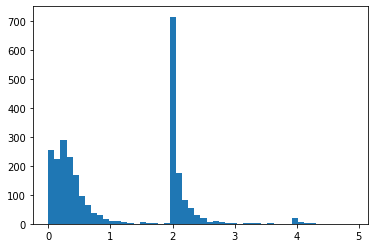

Correct : 0.26272809732560937   Failed: 0.1880229859985654   Mis: 0.21131162394262362  Zero: 0.3379372917250355 Total: 9919.00001
Percentage of adversarial examples generated = 0.5828673661756489
Total number of adversarial examples = 2606
Average number of features modified per sample 2.873369148119724
Average change per sample 1.1116653875671527


In [ ]:
w1 = iter(smodel, 0.1, [], 0.0, 5, 20)
process_merged(w1)
pickle.dump(w1, open('defensive_distaillation.pkl','wb'))

In [ ]:
w1 = pickle.load(open('defensive_distaillation.pkl','rb'))

In [ ]:
# Without any defenses
Correct : 0.5022683733216369   Failed: 0.008771045459450504   Mis: 0.12985179944565803  Zero: 0.35910878076508845 Total: 9919.00001
Percentage of adversarial examples generated = 0.9828368495110735
Total number of adversarial examples = 4982
Average number of features modified per sample 3.7731834604576475
Average change per sample 1.1183862490904757

# With defensive distillation
Correct : 0.26272809732560937   Failed: 0.1880229859985654   Mis: 0.21131162394262362  Zero: 0.3379372917250355 Total: 9919.00001
Percentage of adversarial examples generated = 0.5828673661756489
Total number of adversarial examples = 2606
Average number of features modified per sample 2.873369148119724
Average change per sample 1.1116653875671527

## Adversarial Training

-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
----------------------------------------

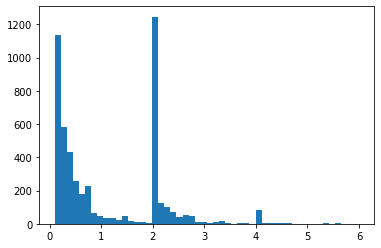

Correct : 0.5022683733216369   Failed: 0.008771045459450504   Mis: 0.12985179944565803  Zero: 0.35910878076508845 Total: 9919.00001
Percentage of adversarial examples generated = 0.9828368495110735
Total number of adversarial examples = 4982
Average number of features modified per sample 3.7731834604576475
Average change per sample 1.1183862490904757
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 80.41600036621094
Accuracy of the validation set 82.93313598632812
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 84.76499938964844
Accuracy of the validation set 85.90746307373047
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 85.1259994506836
Accuracy of the validation set 86.12498474121094
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 85.26200103759766
Accuracy of the validation set 86.26118469238281
--------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------
----------------------------------------

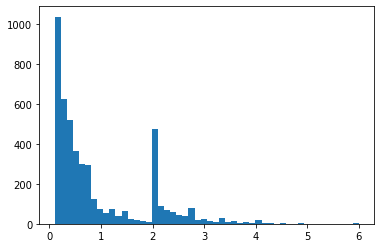

Correct : 0.4707127729905104   Failed: 0.05252545614222658   Mis: 0.14094162703806673  Zero: 0.33582014282103023 Total: 9919.00001
Percentage of adversarial examples generated = 0.8996146418119179
Total number of adversarial examples = 4669
Average number of features modified per sample 5.111158706361105
Average change per sample 0.9117799498688156
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 78.91199493408203
Accuracy of the validation set 81.86875915527344
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 81.98799896240234
Accuracy of the validation set 84.06851959228516
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 82.35099792480469
Accuracy of the validation set 84.2518310546875
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 82.68799591064453
Accuracy of the validation set 84.53778076171875
----------

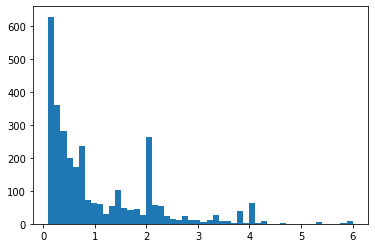

Correct : 0.311624155346684   Failed: 0.21050509102681209   Mis: 0.1337836474102393  Zero: 0.3440871052080985 Total: 9919.00001
Percentage of adversarial examples generated = 0.5968333643621677
Total number of adversarial examples = 3091
Average number of features modified per sample 7.158848269168554
Average change per sample 1.048916271534293
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 77.718994140625
Accuracy of the validation set 81.09484100341797
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 80.73399353027344
Accuracy of the validation set 83.13904571533203
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 81.29899597167969
Accuracy of the validation set 83.40239715576172
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 81.67699432373047
Accuracy of the validation set 83.72577667236328
---------------

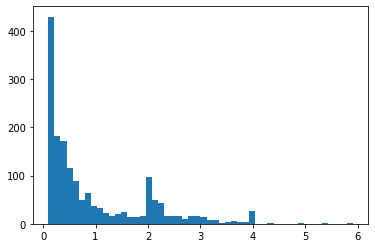

Correct : 0.167658029874324   Failed: 0.37473535600893704   Mis: 0.1257183182521239  Zero: 0.33188829485644894 Total: 9919.00001
Percentage of adversarial examples generated = 0.30910780611690003
Total number of adversarial examples = 1663
Average number of features modified per sample 5.8514732411304875
Average change per sample 0.9555021046301864
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 75.75599670410156
Accuracy of the validation set 78.1934585571289
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 79.95199584960938
Accuracy of the validation set 82.38642883300781
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 80.43699645996094
Accuracy of the validation set 82.15470123291016
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 80.73399353027344
Accuracy of the validation set 83.10612487792969
----------

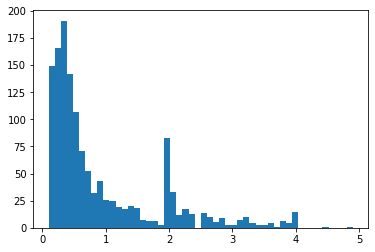

Correct : 0.13721141230243833   Failed: 0.41687670086009004   Mis: 0.11281379159913923  Zero: 0.3330980942301663 Total: 9919.00001
Percentage of adversarial examples generated = 0.24763464292642898
Total number of adversarial examples = 1361
Average number of features modified per sample 5.647318148420279
Average change per sample 0.8914034336827241
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 76.43099975585938
Accuracy of the validation set 78.60010528564453
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 79.46699523925781
Accuracy of the validation set 82.03594207763672
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 80.03599548339844
Accuracy of the validation set 82.4451675415039
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 80.28800201416016
Accuracy of the validation set 81.98236083984375
---------

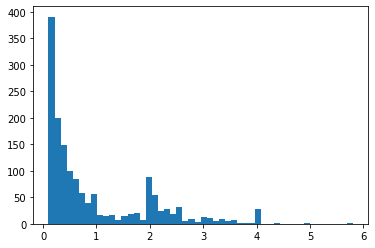

Correct : 0.15515676967924513   Failed: 0.4146587353416083   Mis: 0.1105958260806575  Zero: 0.319588667890323 Total: 9919.00001
Percentage of adversarial examples generated = 0.2722929931488093
Total number of adversarial examples = 1539
Average number of features modified per sample 5.7102014294996755
Average change per sample 0.9539311875609162
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 75.01599884033203
Accuracy of the validation set 78.67626953125
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 78.99400329589844
Accuracy of the validation set 81.42080688476562
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 79.63400268554688
Accuracy of the validation set 81.07160949707031
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 79.88800048828125
Accuracy of the validation set 81.70093536376953
--------------

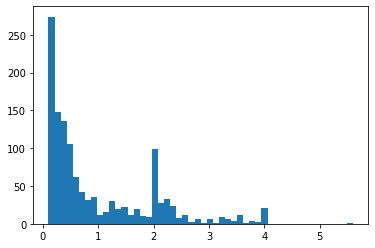

Correct : 0.12723056746927053   Failed: 0.4560943638914262   Mis: 0.09345700161966226  Zero: 0.3232180660114749 Total: 9919.00001
Percentage of adversarial examples generated = 0.2181126854163279
Total number of adversarial examples = 1262
Average number of features modified per sample 6.253565768621236
Average change per sample 0.9786847049574089
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 75.47999572753906
Accuracy of the validation set 78.82860565185547
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 78.4540023803711
Accuracy of the validation set 81.47050476074219
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 78.95899963378906
Accuracy of the validation set 81.47760772705078
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 79.44200134277344
Accuracy of the validation set 81.8177719116211
------------

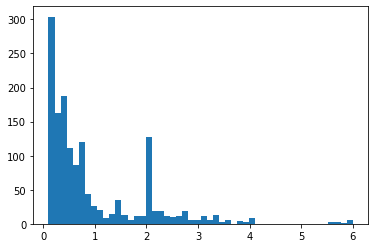

Correct : 0.1465873574487475   Failed: 0.4290755112117396   Mis: 0.10505091228445317  Zero: 0.3192862180468936 Total: 9919.00001
Percentage of adversarial examples generated = 0.2546409802895955
Total number of adversarial examples = 1454
Average number of features modified per sample 6.004814305364512
Average change per sample 0.9447730902628525
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 75.09700012207031
Accuracy of the validation set 78.75114440917969
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 78.25899505615234
Accuracy of the validation set 79.9910888671875
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 78.9020004272461
Accuracy of the validation set 80.71530151367188
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 79.2509994506836
Accuracy of the validation set 81.46147155761719
--------------

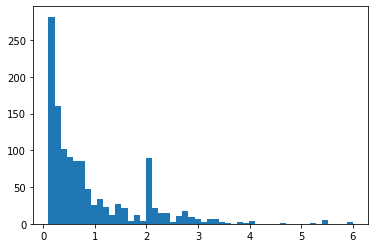

Correct : 0.12491178533631235   Failed: 0.4727291052800392   Mis: 0.0977921160421493  Zero: 0.304566992333333 Total: 9919.00001
Percentage of adversarial examples generated = 0.20900809681341415
Total number of adversarial examples = 1239
Average number of features modified per sample 6.38498789346247
Average change per sample 0.9033091793722255
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 74.25299835205078
Accuracy of the validation set 76.74373626708984
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 78.0739974975586
Accuracy of the validation set 79.98786926269531
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 78.63599395751953
Accuracy of the validation set 80.3047866821289
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 78.95800018310547
Accuracy of the validation set 80.75080871582031
--------------

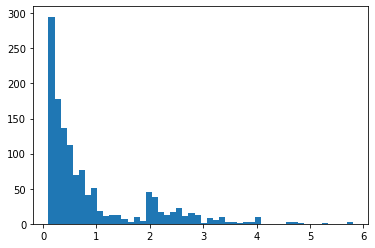

Correct : 0.1290452665298465   Failed: 0.43683839052642565   Mis: 0.09254965208937428  Zero: 0.34156668984618743 Total: 9919.00001
Percentage of adversarial examples generated = 0.22804204484581855
Total number of adversarial examples = 1280
Average number of features modified per sample 5.62109375
Average change per sample 0.8818750381469727
---------------------------------------------------
Epoch Number 0
Accuracy of the train set 74.68999481201172
Accuracy of the validation set 76.38033294677734
---------------------------------------------------
Epoch Number 1
Accuracy of the train set 78.40699768066406
Accuracy of the validation set 80.7269287109375
---------------------------------------------------
Epoch Number 2
Accuracy of the train set 78.85099792480469
Accuracy of the validation set 80.8050308227539
---------------------------------------------------
Epoch Number 3
Accuracy of the train set 79.22599792480469
Accuracy of the validation set 81.03417205810547
-----------------

In [ ]:
tadx = []
tt = []
store = []

for i in range(10):
  res = iter(model, 0.1, [], 0.0, 5, 20) # generate adversarial samples
  process_merged(res)

  adx = []   # List of adversarial examples

  for i in res:
    for j in i[1]:
      adx.append(j.cpu().numpy())

  # Create dataset by merging the normal sample with adversarial samples

  if(len(adx) > 100):
    f = int(0.2 * len(adx))
    tadx.append(adx[0:f])
    adx = adx[f:]

    if(len(store)==0):
      store = adx
    else:
      store = np.array(store)
      store = np.concatenate([store, adx], axis=0)
      

    store = np.array(store)
    space = 0
    if(len(store)>15000):
      space = 15000
    else:
      space = len(store)

    index = np.random.choice(len(ds[0]), 100000 - space, replace = False)
    X = ds[0][index]
    Y = ds[2][index]

    index = np.random.choice(len(store), space, replace = False)
    select = store[index]

    X = np.concatenate([select, X], axis=0)
    Y = np.concatenate([np.ones(len(select)), Y], axis=0)
    X, Y = shuffle(X,Y)
  
  else:
    print("Done!")
    break

  trainx = torch.from_numpy(X).type(torch.float)
  trainy = torch.from_numpy(Y).type(torch.float)#.unsqueeze(1)
  testx = torch.from_numpy(ds[1]).type(torch.float)
  testy = torch.from_numpy(ds[3]).type(torch.float)#.unsqueeze(1)

  train_data = TensorDataset(trainx, trainy)
  test_data = TensorDataset(testx, testy)

  train_dataloader = DataLoader(train_data, shuffle = True, batch_size = 512)
  test_dataloader = DataLoader(test_data, shuffle = True, batch_size = 512)

  model = ModelNN().to(device)

  ## Training and testing phases

  epochs = 300
  loss_fn = nn.BCELoss()
  optim = torch.optim.Adam(model.parameters(),lr=0.001)
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []

  for ep in range(epochs):
    # if(ep==100):
    #   optim = torch.optim.Adam(model.parameters(),lr=0.0001)
    # elif(ep==200):
    #   optim = torch.optim.Adam(model.parameters(),lr=0.00001)
    print("---------------------------------------------------")
    print(f"Epoch Number {ep}")
    correct = 0
    total = 0
    for phase in ['train', 'validate']:

      if(phase=='train'):
        model.train(True)
        loader = train_dataloader
      elif(phase=='validate'):
        model.train(False)
        loader = test_dataloader

      for batch, (X, y) in enumerate(loader):
        # if(batch%100==0):
        #   print(f"Handing batch number: {batch} in phase {phase}")
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y)

        if(phase=='train'):
          optim.zero_grad()
          loss.backward()
          optim.step()
          y_pred = ((y_pred > 0.5)*1.0)
          correct += (y_pred==y).sum()
          total += len(y)

        elif(phase=='validate'):
          y_pred = ((y_pred > 0.5)*1.0)
          #print(f"Testing Loss = {loss_fn(y_pred, y)}")
          correct += (y_pred==y).sum()
          total += len(y)

      acc = 100 * (correct/total)
      if(phase=='validate'): 
        test_acc.append(acc.item())
        test_loss.append(loss.item())
        print(f"Accuracy of the validation set {acc}")
      elif(phase=='train'):
        train_acc.append(acc.item())
        train_loss.append(loss.item())
        print(f"Accuracy of the train set {acc}")

  for ii in tadx:
    ii = torch.Tensor(ii)
    ypred = model(ii.to(device))
    ypred = (ypred > 0.5)*1.0
    print(classification_report(np.ones(len(ii),), ypred.to('cpu').numpy()))
    print(confusion_matrix(np.ones(len(ii),), ypred.to('cpu').numpy()))
    tt.append(accuracy_score(np.ones(len(ii),), ypred.to('cpu').numpy()))

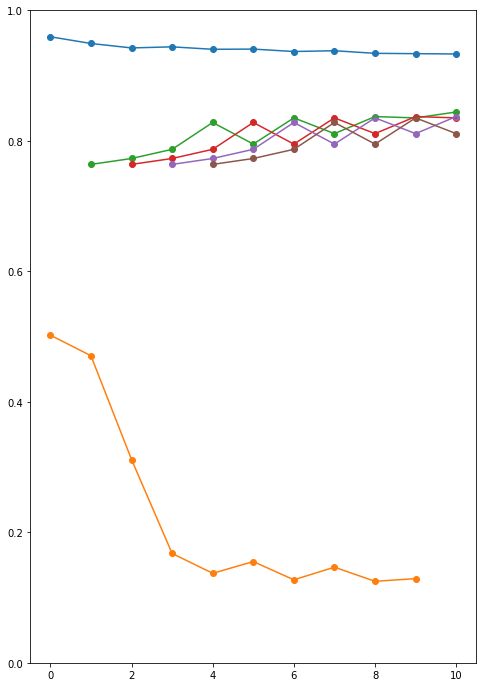

In [ ]:
# Analysing the results of the adversarial training

rr = []

for i in range(10):
  temp = []
  #temp.append(0)
  k = 0
  for j in range(10-i):
    temp.append(tt[k])
    k = k+j+1
  rr.append(temp)

pickle.dump(rr,open('adversarial_accuracy.pkl','wb'))


# Accuracy of the DNN model on the test set
plt.figure(figsize=(8,12))
acc = [95.97, 94.94, 94.26, 94.425, 94.05, 94.08, 93.71, 93.83, 93.43, 93.38, 93.33]
acc = np.array(acc)/100
plt.plot(np.arange(0,11), acc)
plt.scatter(np.arange(0,11), acc)


# % adversarial samples successfully generated
sam = [4982, 4669, 3091, 1663, 1361, 1539, 1262, 1454, 1239, 1280]
sam = np.array(sam)/9919
plt.plot(np.arange(0,10), sam)
plt.scatter(np.arange(0,10), sam)

# Performance of the DNN model on detecting multiple versions of the adversarial samples
for i in range(4):
  plt.ylim(0,1)
  plt.plot(np.arange(i+1,11), rr[i])
  plt.scatter(np.arange(i+1,11), rr[i])

plt.show()

## DAE

In [ ]:
# Denoising Auto Encoder

class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    self.dp = nn.Dropout(p=0.0)
    self.lr = nn.LeakyReLU(0.35)

    self.fc1 = nn.Linear(44,40)
    self.fc2 = nn.Linear(40,30)
    self.fc3 = nn.Linear(30,15)
    self.fc4 = nn.Linear(15,5)  
    self.fc5 = nn.Linear(5,15)
    self.fc6 = nn.Linear(15,30)
    self.fc7 = nn.Linear(30,40)
    self.fc8 = nn.Linear(40,44)
    
  def forward(self,x):
    x = self.lr(self.fc1(x))
    x = self.dp(x)
    x = self.lr(self.fc2(x))
    x = self.dp(x)
    x = self.lr(self.fc3(x))
    x = self.dp(x)
    x = self.lr(self.fc4(x))
    x = self.dp(x)
    x = self.lr(self.fc5(x))
    x = self.dp(x)
    x = self.lr(self.fc6(x))
    x = self.dp(x)
    x = self.lr(self.fc7(x))   
    x = self.dp(x)
    x = self.lr(self.fc8(x))
    return x

In [ ]:
bba = pickle.load(open('bba.pkl','rb'))

adx = []
diff = []
ady = []

for i in bba:
  for j in i[1]:
    adx.append(j.numpy())

for i in bba:
  for j in i[5]:
    diff.append(j)

for i in range(len(adx)):
  ady.append(adx[i]+diff[i])

adx, ady = shuffle(adx, ady)

In [ ]:
## Creating the train and test datasets 

f = int(1 * len(adx))
train_ax = adx[0:f]
test_ax = adx[f:]

train_ay = ady[0:f]
test_ay = ady[f:]

index = np.random.choice(len(ds[0]), 20000-f)

trxm =  np.concatenate([train_ax, ds[0][index]+ np.random.normal(-0.05,0.05,np.shape(ds[0][index]))])
trym = np.concatenate([train_ay, ds[0][index] ])

from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler = scaler.fit(trxm)
# trxm = scaler.transform(trxm)
# trym = scaler.transform(trym) 
# tt = scaler.transform(ds[1])
tt = ds[1]


trainx = torch.from_numpy(trxm).type(torch.float)
trainy = torch.from_numpy(trym).type(torch.float)#.unsqueeze(1)
testx = torch.from_numpy(tt).type(torch.float)
testy = torch.from_numpy(tt).type(torch.float)#.unsqueeze(1)

train_data = TensorDataset(trainx, trainy)
test_data = TensorDataset(testx, testy)

train_dataloader = DataLoader(train_data, shuffle = True, batch_size = 512)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = 512)

## Building the DNN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using the device: " + device)

Using the device: cpu


In [ ]:
ae = AE().to(device)

## Training and testing phases

epochs = 300

c_loss = nn.MSELoss()
b_loss = nn.BCELoss() 
sig = nn.Sigmoid()

def loss_fun(output, target):
  o1 = output[0:9]
  t1 = target[0:9]

  o2 = output[9:]
  o2 = sig(o2)
  t2 = target[9:]

  #print(o2, c_loss(o1, t1).item(), b_loss(o2,t2).item())

  total_loss = 10 * c_loss(o1, t1) + b_loss(o2, t2)

  return total_loss

loss_fn = c_loss
optim = torch.optim.Adam(ae.parameters(),lr=0.0001)
train_loss = []
test_loss = []

for ep in range(epochs):
  # if(ep==100):
  #   optim = torch.optim.Adam(model.parameters(),lr=0.0001)
  # elif(ep==200):
  #   optim = torch.optim.Adam(model.parameters(),lr=0.00001)
  print("---------------------------------------------------")
  print(f"Epoch Number {ep}")
  correct = 0
  total = 0
  for phase in ['train', 'validate']:

    if(phase=='train'):
      ae.train(True)
      loader = train_dataloader
    elif(phase=='validate'):
      ae.train(False)
      loader = test_dataloader

    for batch, (X, y) in enumerate(loader):
      # if(batch%100==0):
      #   print(f"Handing batch number: {batch} in phase {phase}")
      X = X.to(device)
      y = y.to(device)

      y_pred = ae(X).squeeze()
      loss = loss_fn(y_pred, y)

      if(phase=='train'):
        optim.zero_grad()
        loss.backward()
        optim.step()

    if(phase=='validate'): 
      test_loss.append(loss.item())
      print(f"Loss of the validation set {loss.item()}")
    elif(phase=='train'):
      train_loss.append(loss.item())
      print(f"Loss of the train set {loss.item()}")

---------------------------------------------------
Epoch Number 0
Loss of the train set 0.23164886236190796
Loss of the validation set 0.33883583545684814
---------------------------------------------------
Epoch Number 1
Loss of the train set 0.17872405052185059
Loss of the validation set 0.35447368025779724
---------------------------------------------------
Epoch Number 2
Loss of the train set 0.29127243161201477
Loss of the validation set 0.23870810866355896
---------------------------------------------------
Epoch Number 3
Loss of the train set 0.28566598892211914
Loss of the validation set 0.2357053905725479
---------------------------------------------------
Epoch Number 4
Loss of the train set 0.19138717651367188
Loss of the validation set 0.2007571905851364
---------------------------------------------------
Epoch Number 5
Loss of the train set 0.24169158935546875
Loss of the validation set 0.23006987571716309
---------------------------------------------------
Epoch Number 6

In [ ]:
torch.save(ae.state_dict() ,'ae.pkl')

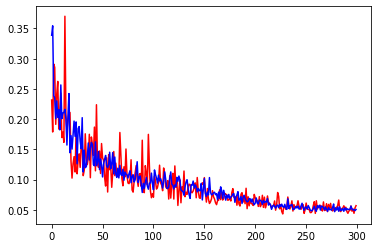

In [ ]:
x = np.arange(0,len(train_loss))

plt.plot(x, train_loss, c='r')
plt.plot(x, test_loss, c='b')
plt.show()

In [ ]:
processed = ae(torch.from_numpy(np.array(train_ax)).type(torch.float).to(device))

output = model(processed).cpu().detach().numpy()
output = 1.0 * (output > 0.5)

confusion_matrix(np.ones(len(output,)), output)

array([[   0,    0],
       [3957,  685]])

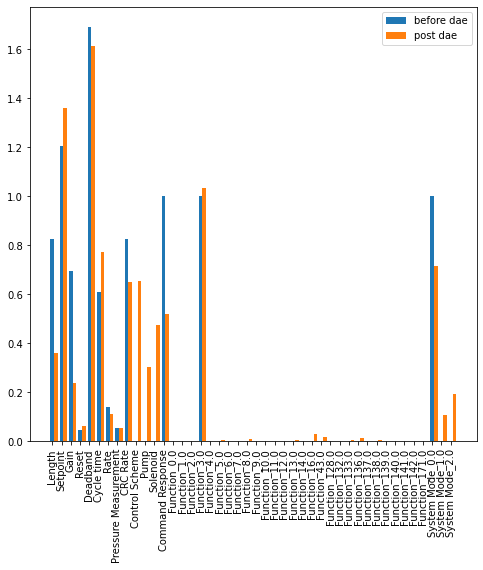

In [ ]:
# Testing the effect of the DAE on a random point   ---->    The attack characteristics of a packet is modified [Not applicable]

qq = ds[1][90]
uu = ae(torch.from_numpy(qq).type(torch.float).to(device)).cpu().detach().numpy()

plt.figure(figsize=(8,8))
plt.bar(2*np.arange(44), np.abs(qq), label='before dae')
plt.bar(0.8+2*np.arange(44), np.abs(uu), label='post dae')
plt.xticks(2*np.arange(44), names[:-1], rotation=90)
plt.legend()
plt.show()

# SHAP Analysis [Basic]


In [ ]:
# explainer = shap.TreeExplainer(clf)

# chosen = pd.DataFrame(X_test[0:1000,:])
# chosen.columns = names

# shap_values = explainer.shap_values(chosen)
# chosen.to_csv('chosen.csv')

# import pickle
# open_file = open("p_shap.pkl", "wb")
# pickle.dump(shap_values, open_file)
# open_file.close()

In [ ]:
chosen = pd.read_csv('chosen.csv')

open_file = open("p_shap.pkl","rb")
pshap = pickle.load(open_file)
open_file.close()

In [ ]:
attacks_cat = ['Normal', 'NMRI', 'CMRI','MSCI', 'MPCI', 'MDCI', 'DOS', 'Recon']
attack_bin = ['Normal', 'Attack']

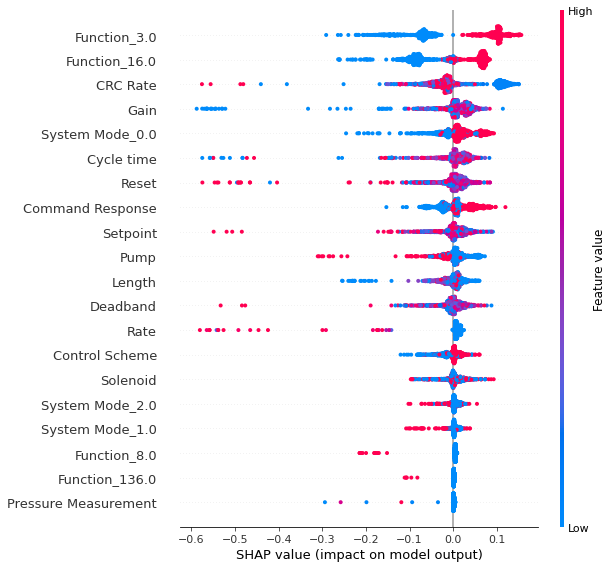

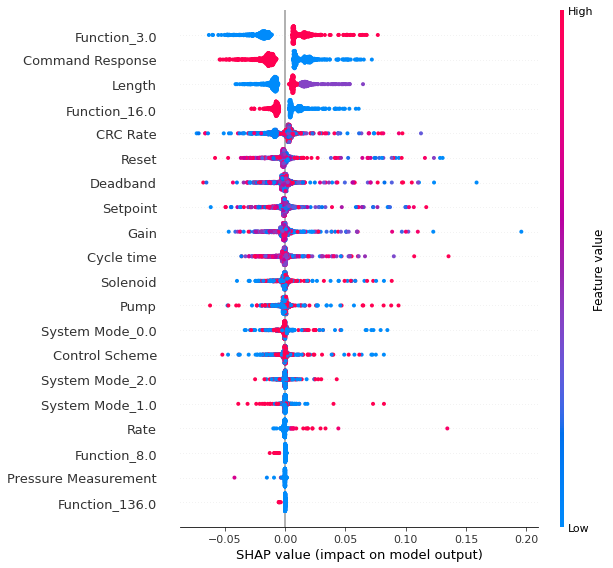

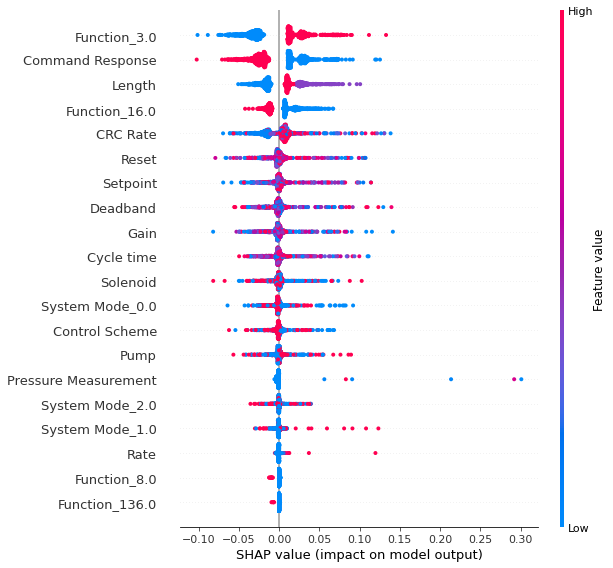

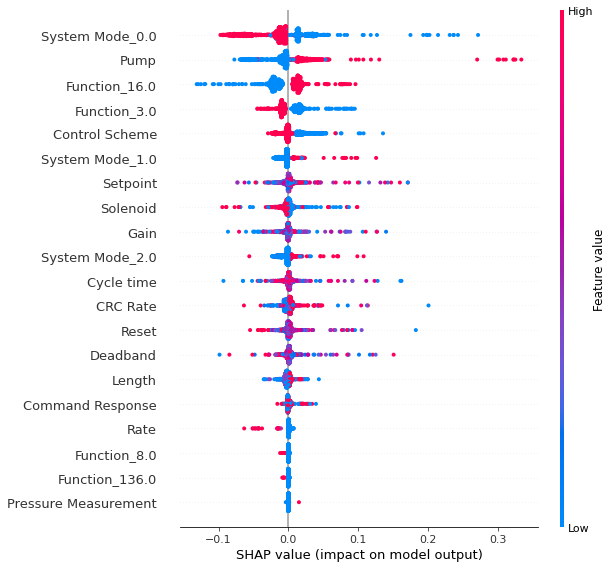

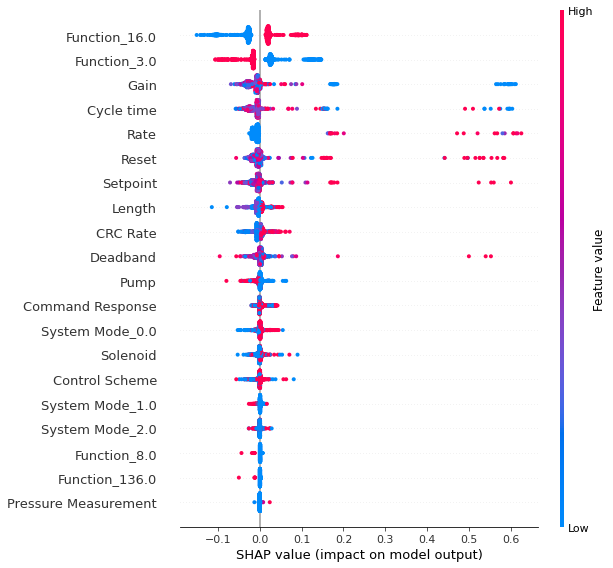

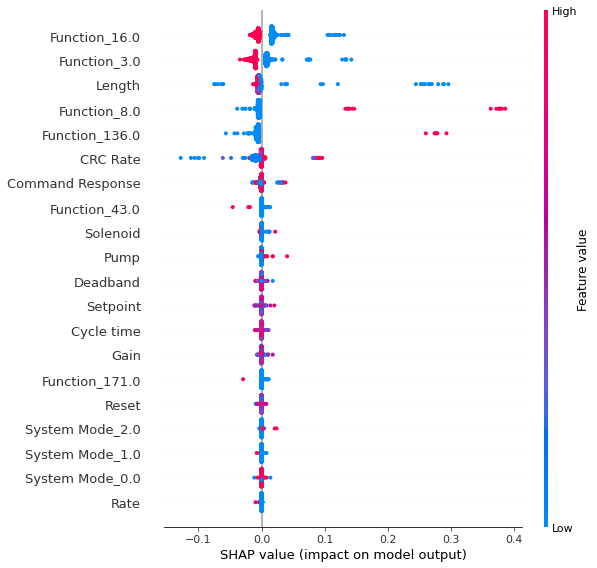

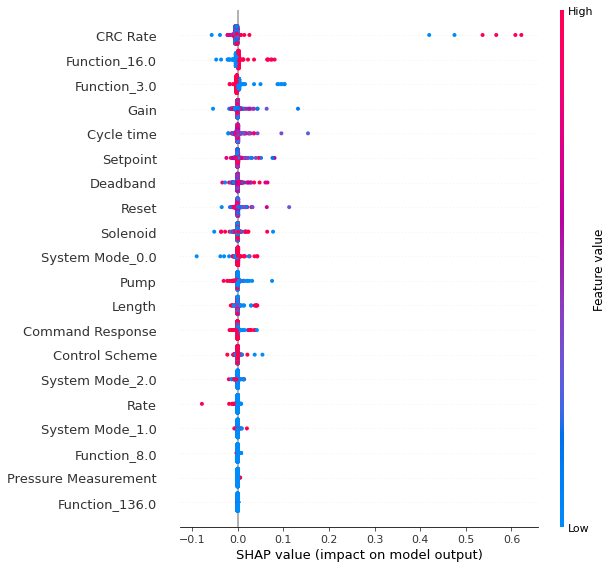

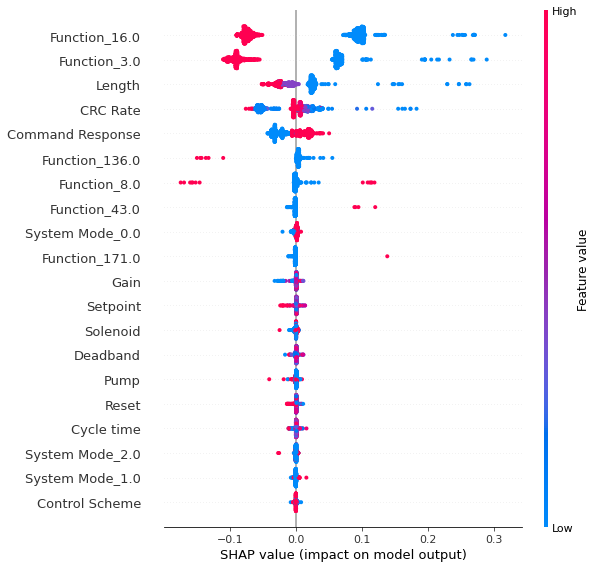

In [ ]:
import matplotlib.pyplot as plt

for i in range(np.shape(pshap)[0]):
  shap.summary_plot(pshap[i], chosen, show=False)
  file_name = './SHAP_CAT/summary_plot_' + str(i) + '_' + attacks_cat[i] + '.png'
  plt.savefig(file_name, bbox_inches='tight')
  plt.show()

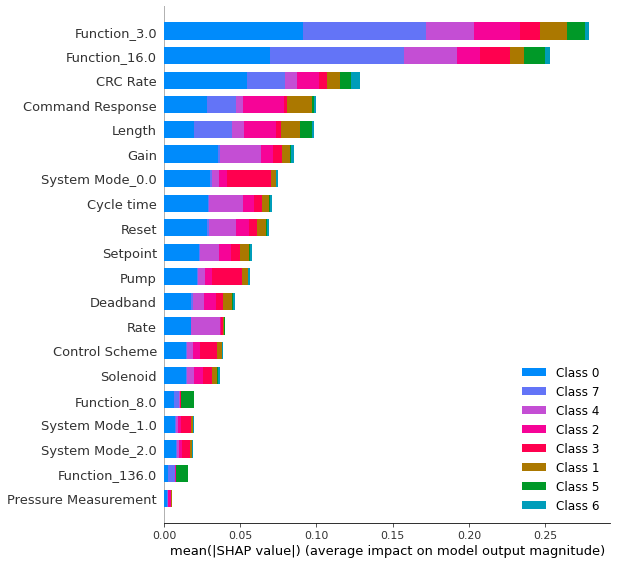

In [ ]:
shap.summary_plot(pshap, chosen, plot_type='bar', show=False)
plt.savefig("./SHAP_CAT/feature_importance.png", bbox_inches='tight')

mkdir: cannot create directory ‘0_Normal’: File exists


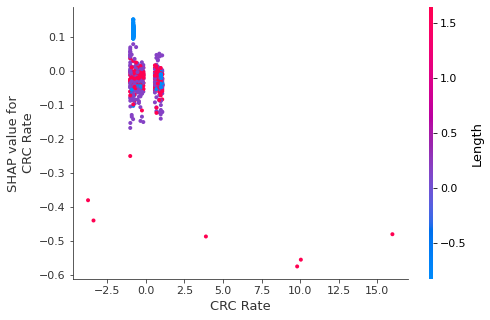

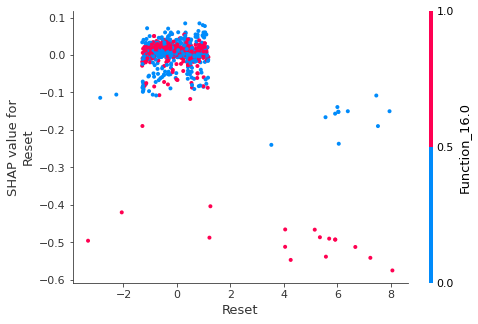

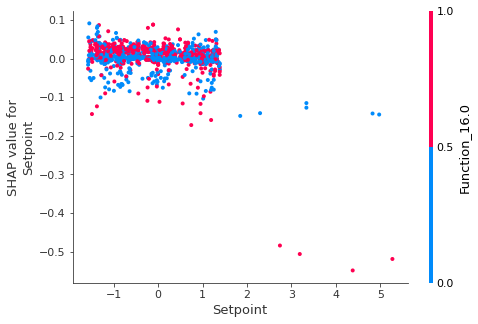

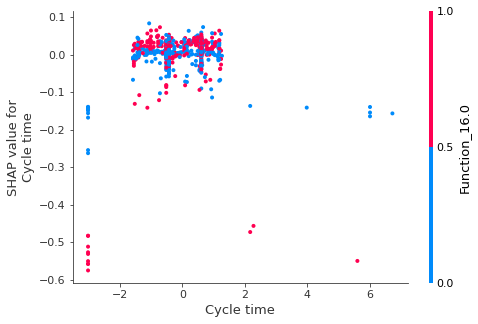

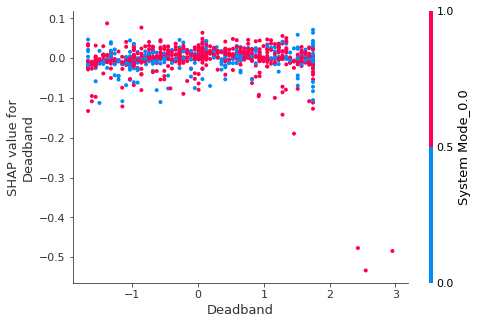

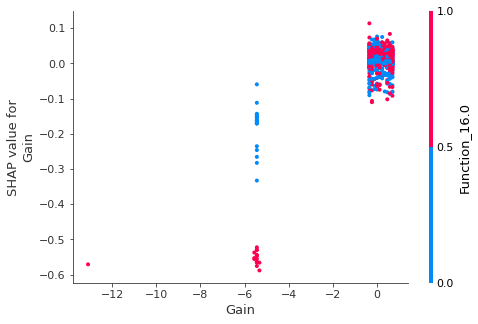

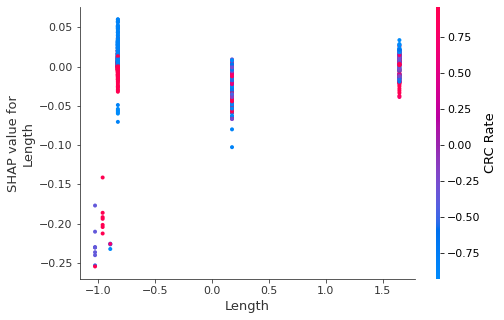

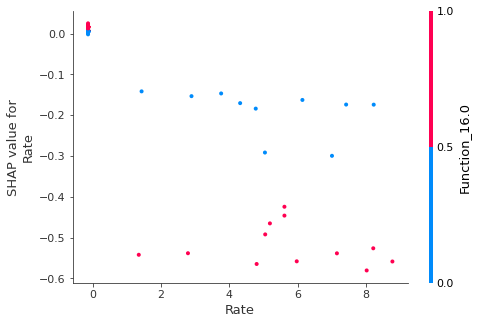

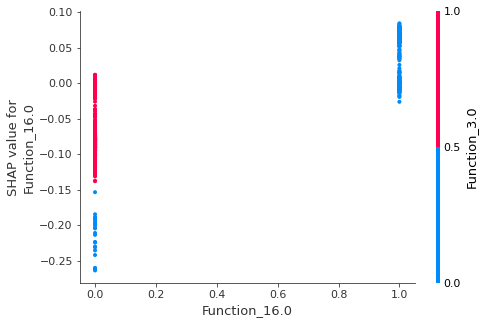

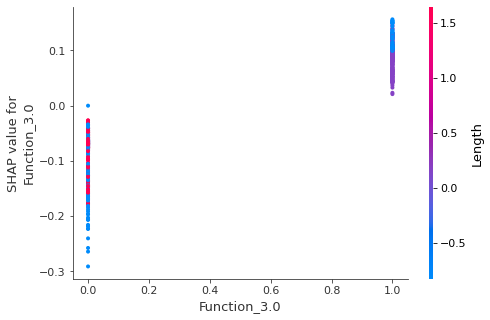

******************************


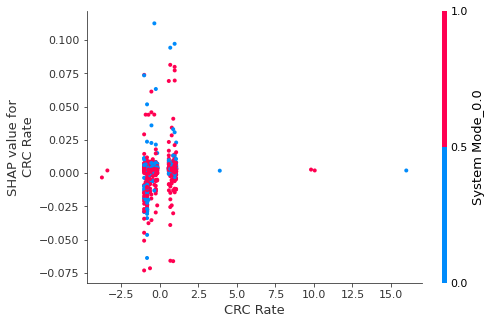

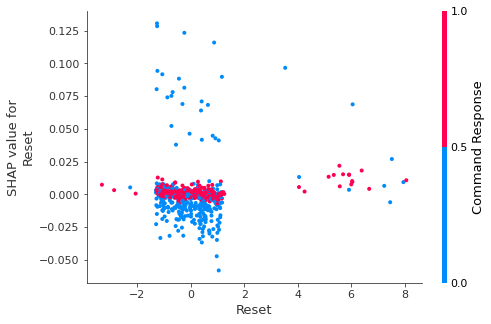

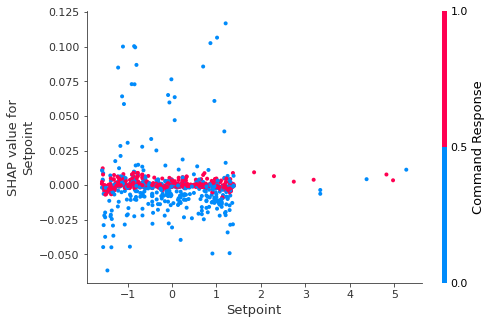

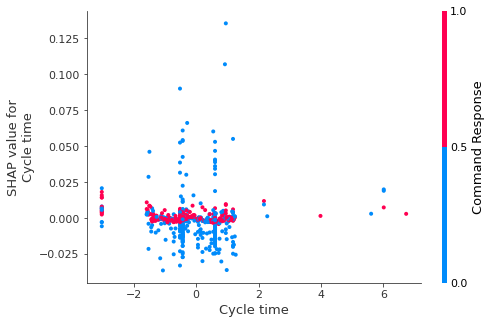

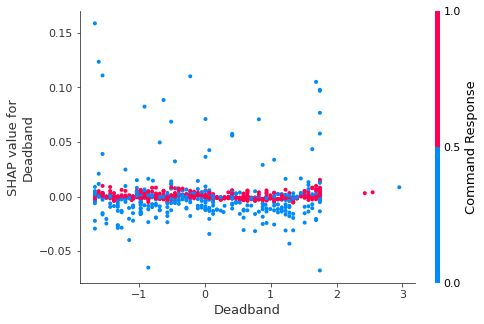

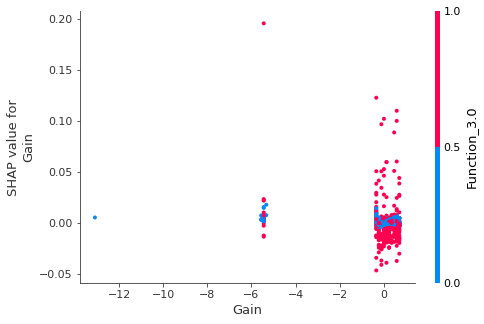

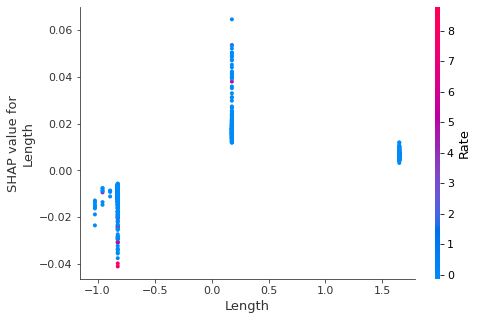

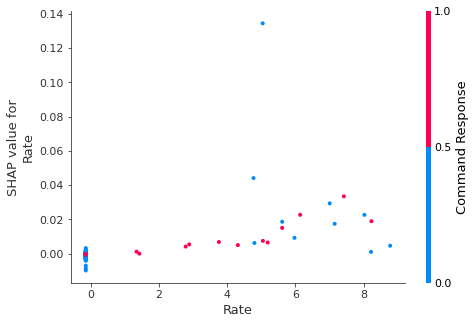

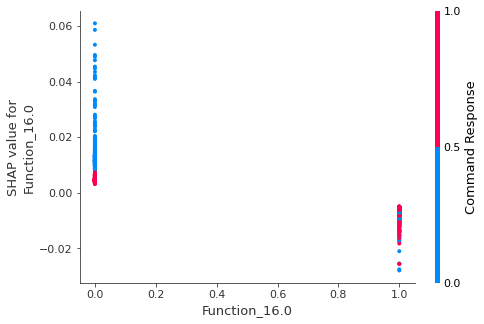

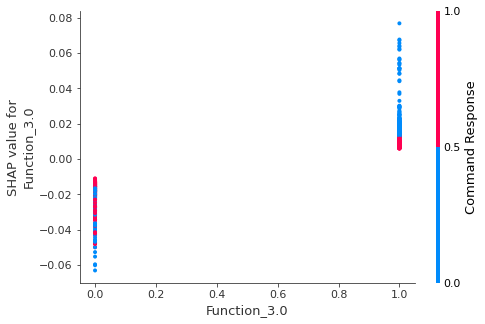

******************************


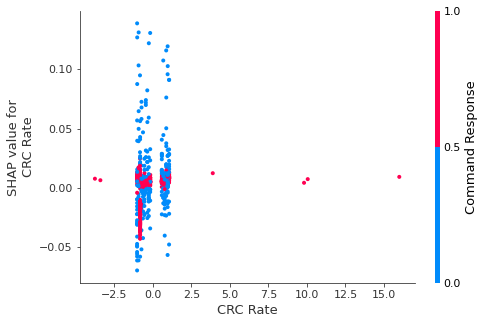

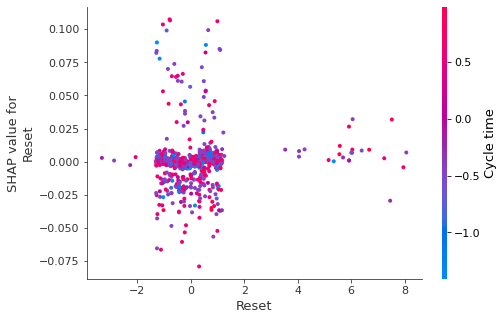

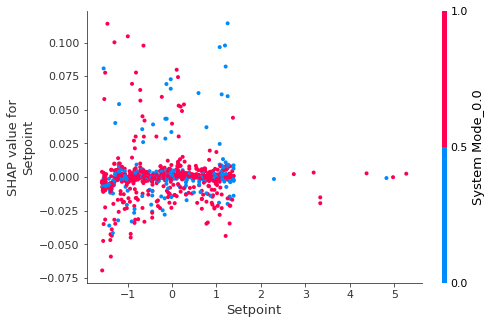

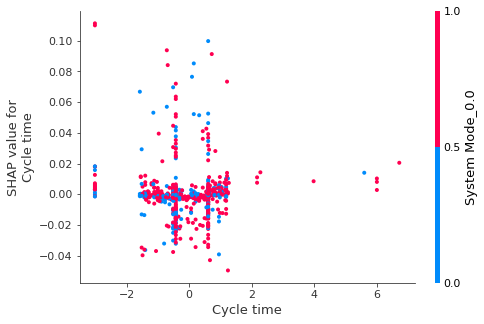

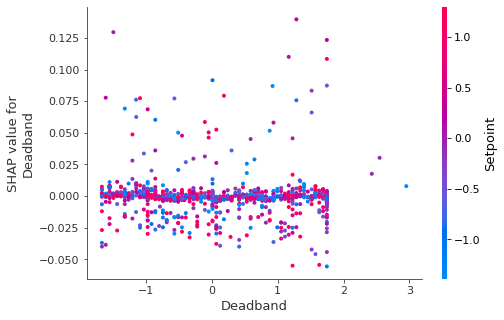

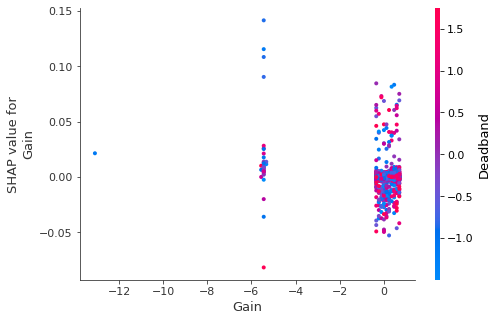

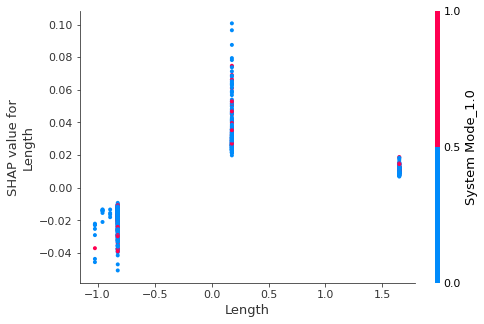

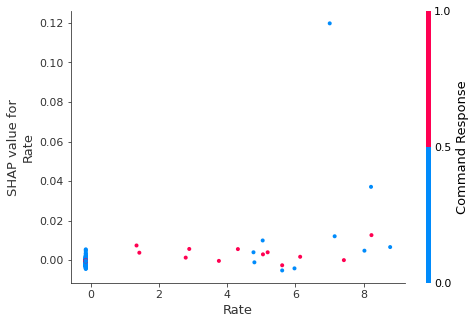

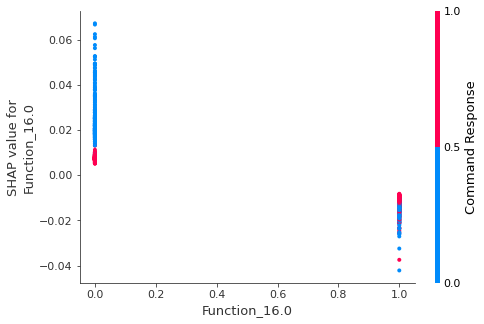

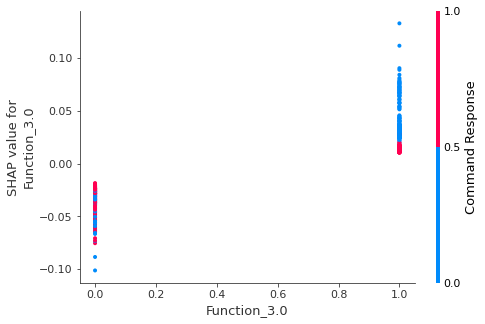

******************************


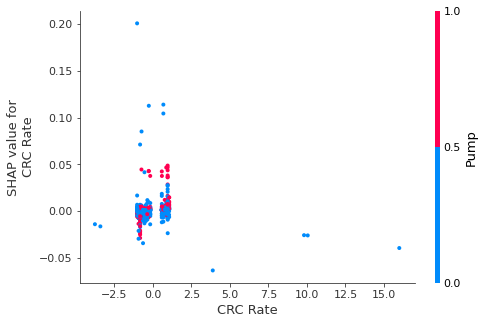

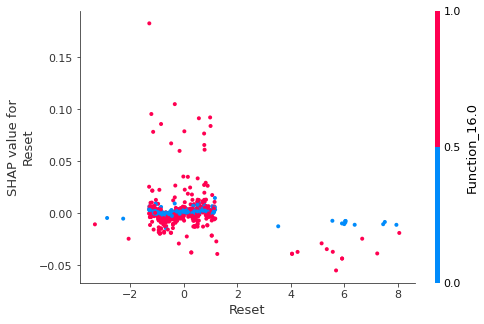

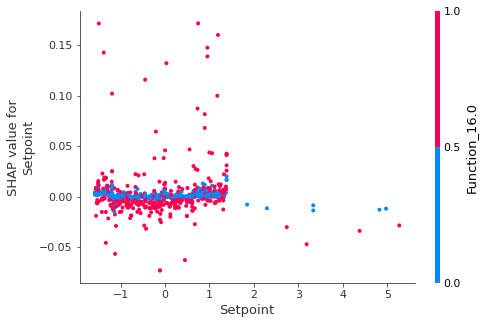

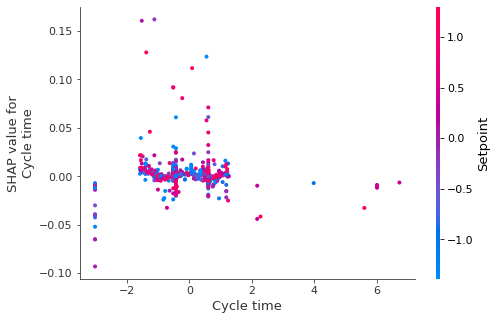

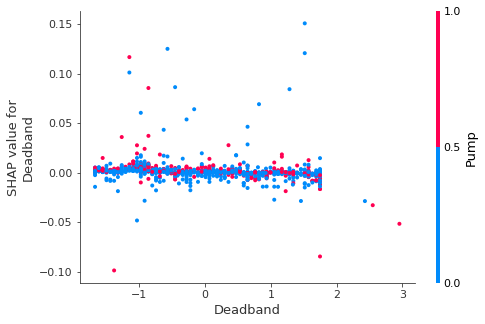

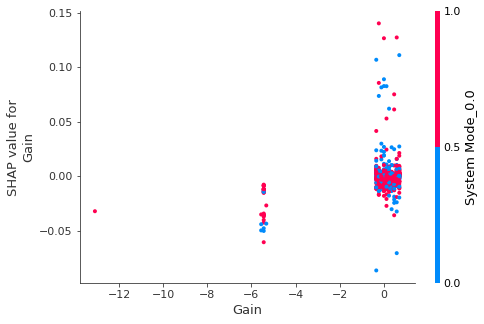

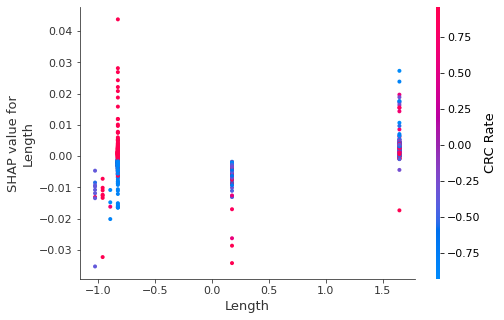

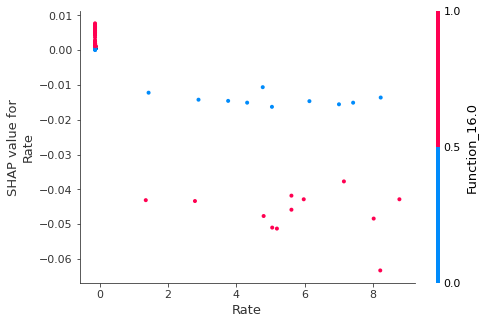

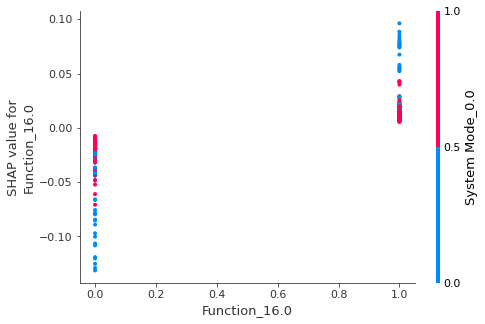

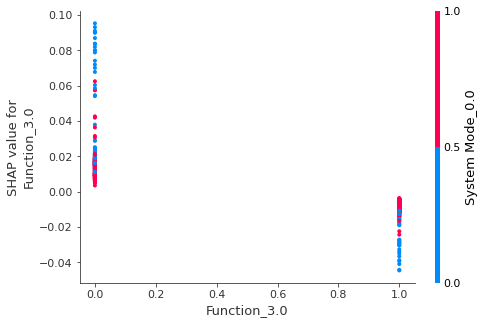

******************************


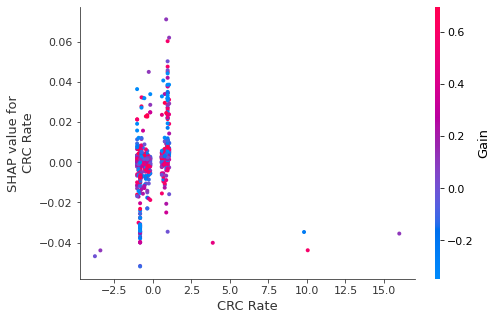

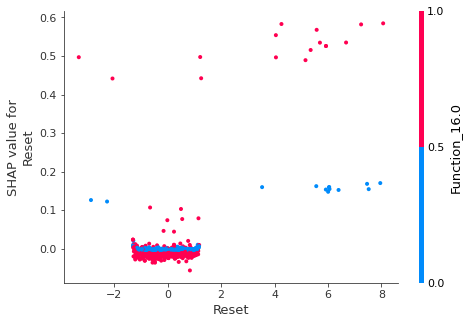

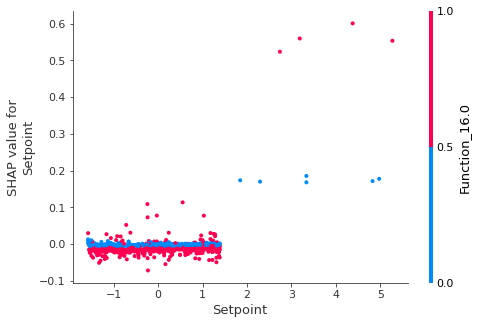

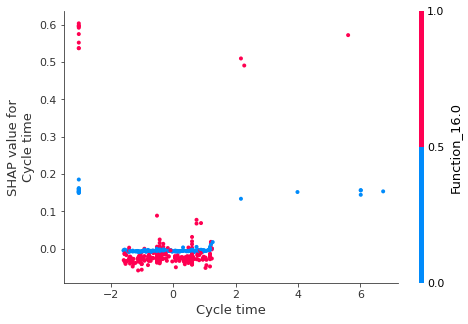

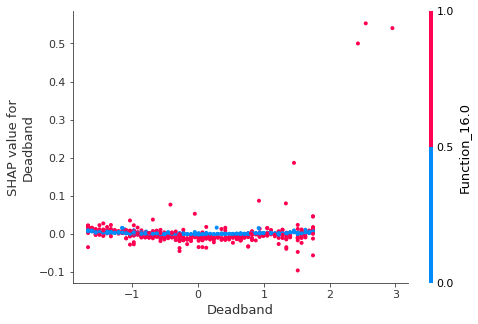

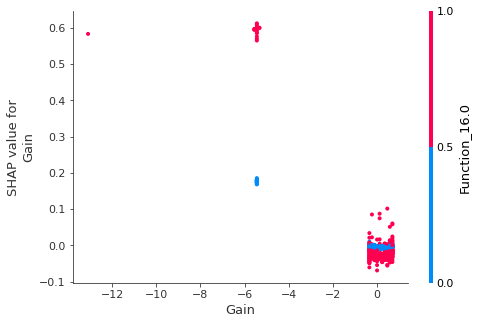

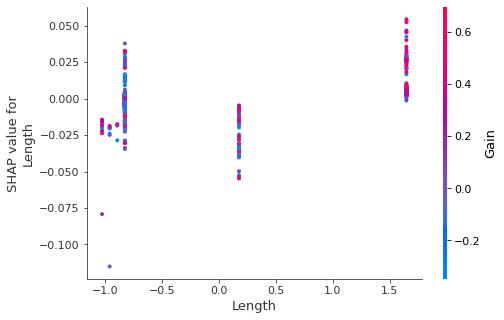

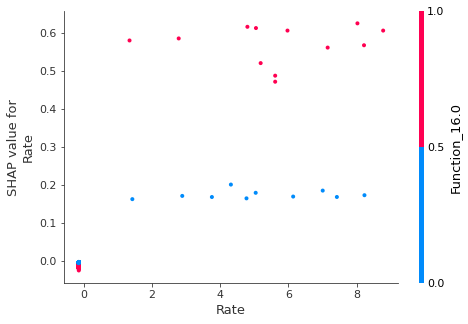

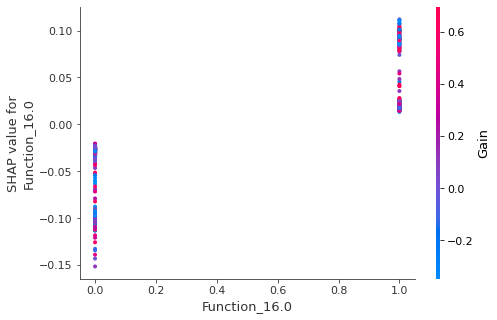

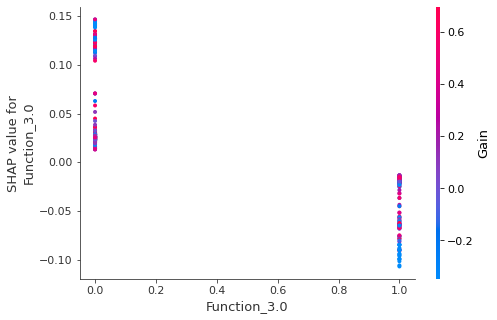

******************************


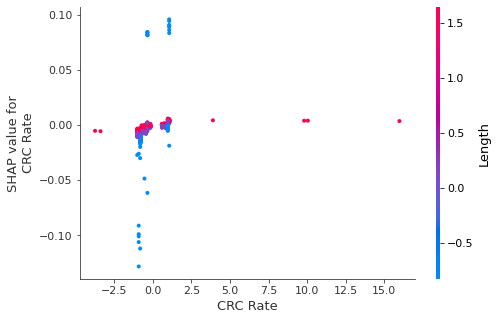

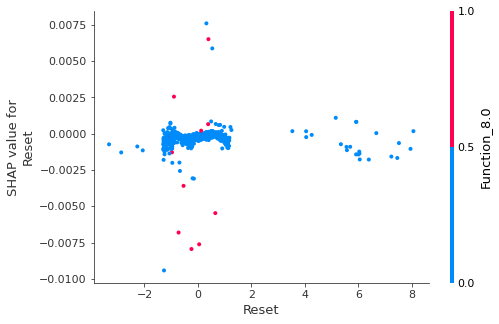

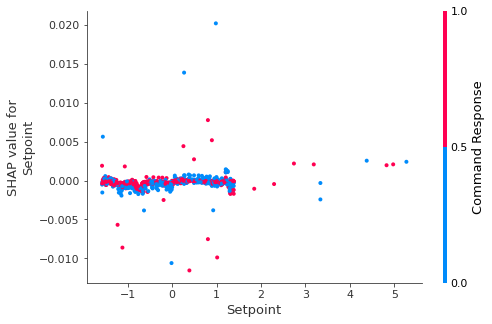

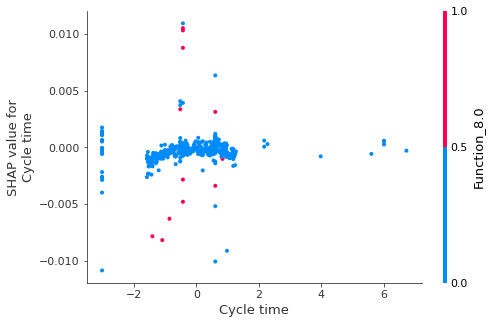

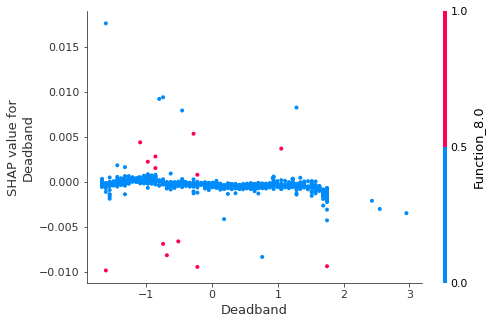

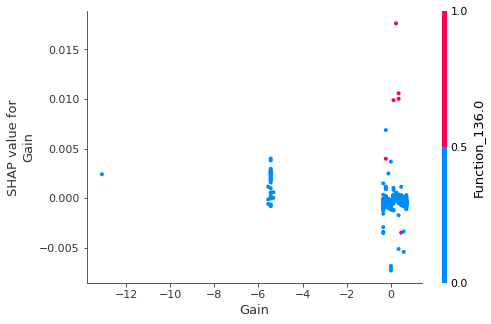

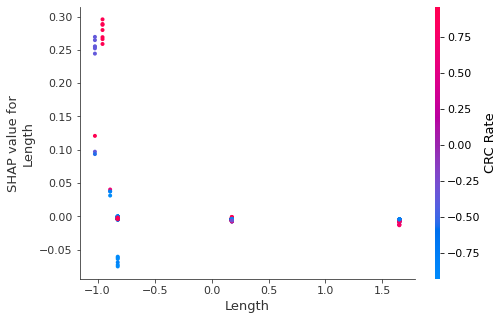

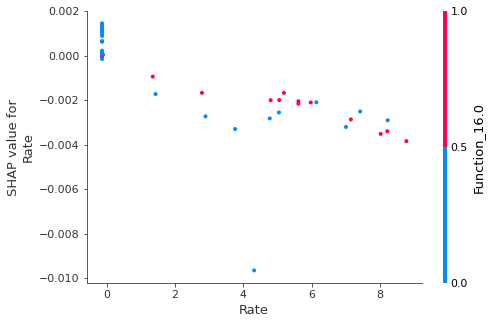

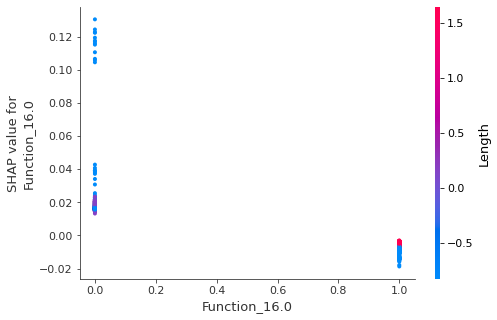

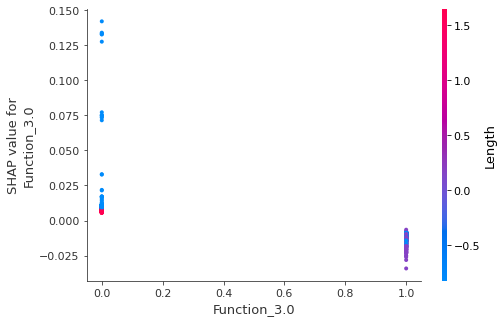

******************************


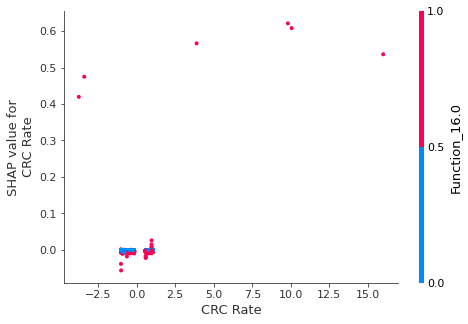

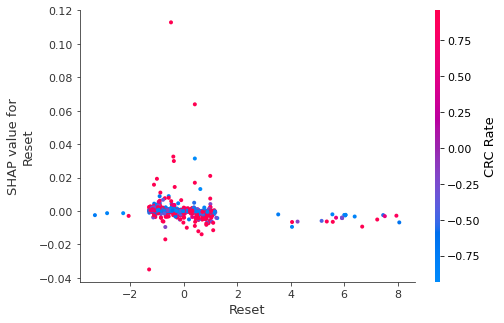

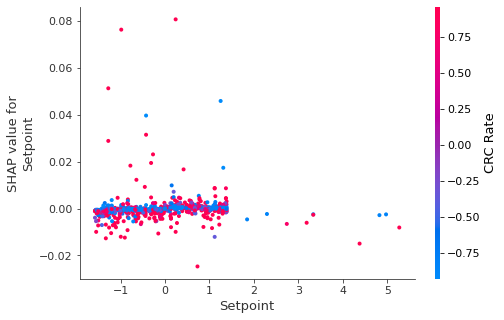

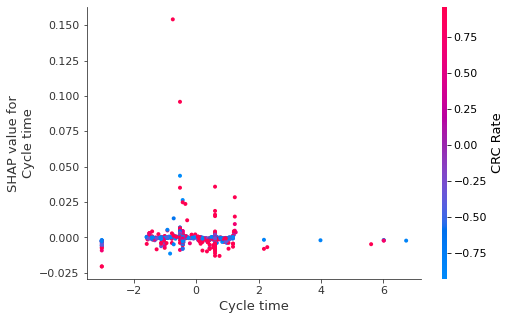

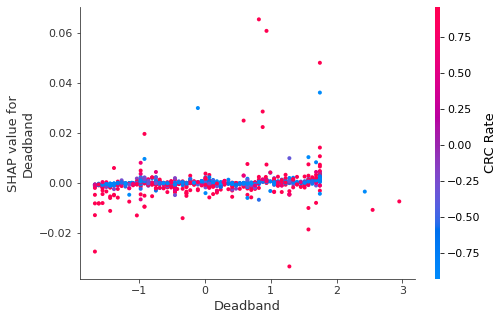

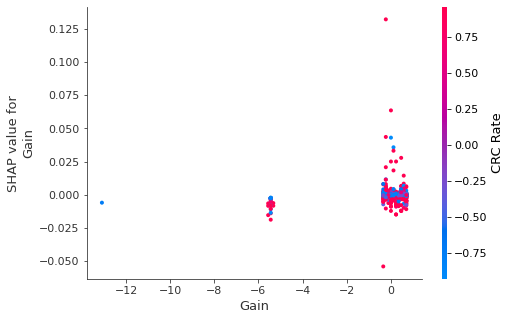

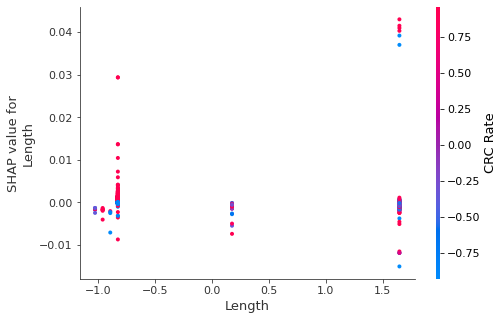

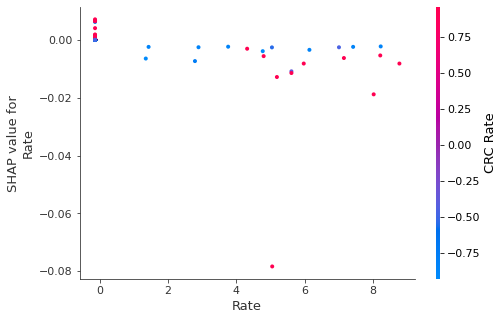

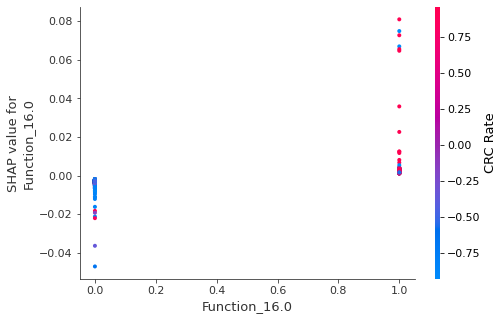

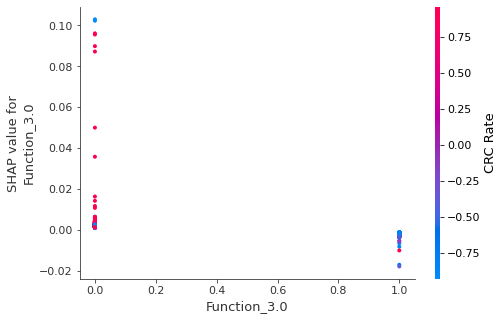

******************************


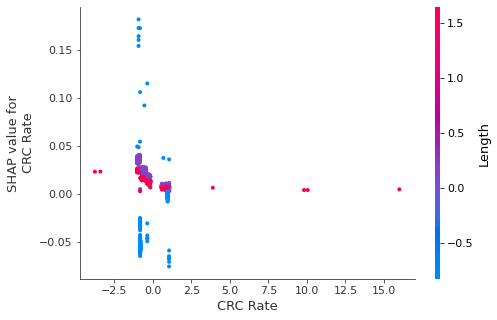

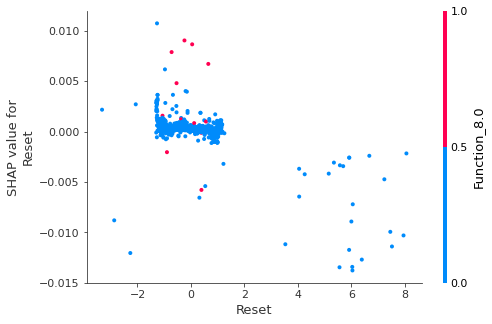

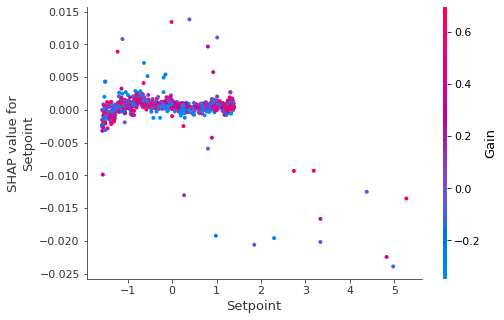

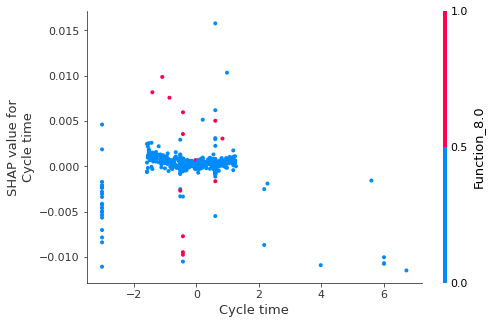

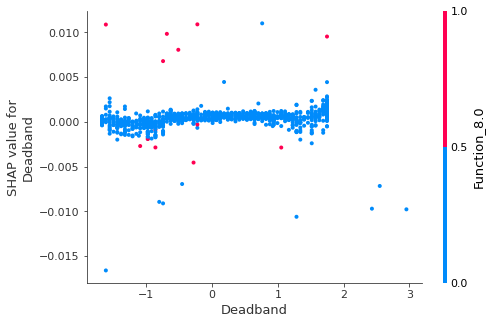

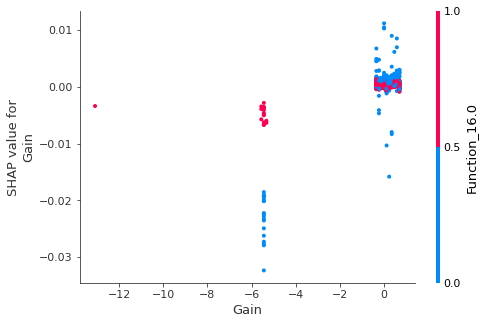

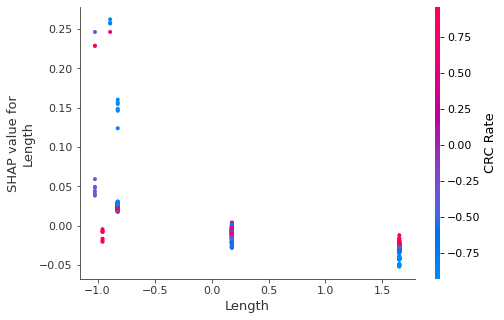

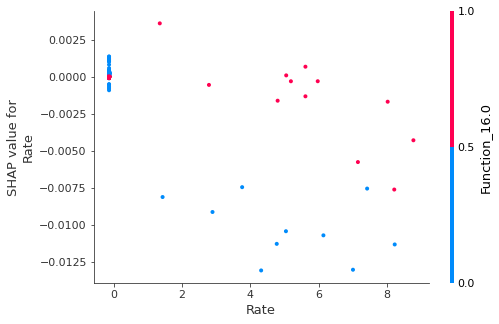

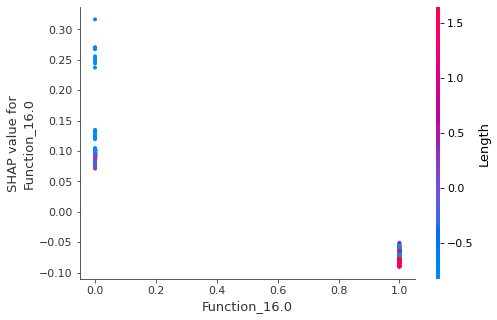

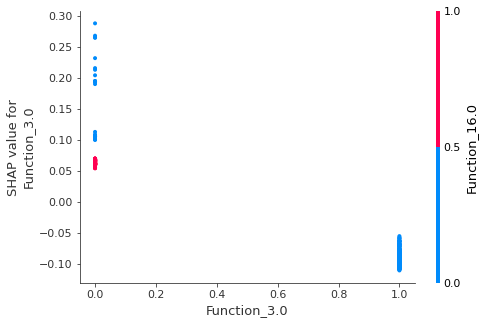

******************************


In [ ]:
os.chdir("/content/drive/My Drive/ICS_IDS/SHAP_CAT/PDP")
for i in range(8):
  folder = str(i) + '_' + attacks_cat[i]
  !mkdir $folder
  for name in ['CRC Rate', 'Reset', 'Setpoint', 'Cycle time', 'Deadband', 'Gain', 'Length', 'Rate', 'Function_16.0', 'Function_3.0']:
    shap.dependence_plot(name, pshap[i], chosen, show=False)
    plt.savefig("./" + folder + '/' + name + ".png",bbox_inches='tight' )
    plt.show()
  print("******************************")